# USA Resiliece Opportunity Mapping Data Processing

The data that we have selected for the platform can be seen here: 
https://docs.google.com/spreadsheets/d/1xEHzYpkWgZTu_DNXw3YDk3LNI7iVEDfP/edit#gid=1856162673&fvid=1697691070

## Table of Contents
- ## [Python libraries](#libraries)
- ## [Utils](#utils)
- ## [List of datasets and indicators](#datasets)
- ## [Read vector data](#vector_data)
    - **[Sates](#states)**
    - **[County](#county)**  
    - **[Census tract](#tract)**
- ## [Preprocess carto data](#carto_data)

<a id='libraries'></a>
## Python libraries

In [1]:
from matplotlib import pyplot as plt
import LMIPy as lmi
import geopandas as gpd
import shapely.wkt
import pandas as pd
import requests
import zipfile
import json
import io
import os

<a id='utils'></a>
## Utils

In [2]:
#import functions form notebook
%run './preprocessing_main_functions.ipynb'

<a id='datasets'></a>
## List of datasets and indicators
**Datasets**

In [ ]:
datasets = {
    'gee':{
        'extreme_heat_days':'4077d297-c3d4-4302-8e2b-2a1701a24d8d',
        'extreme_precipitation_days':'6a818d38-2361-4c9a-bd9e-c0cd3493d5ce',
        'landslide_susceptibility':'ea2db3a6-49c8-4d41-a2ab-758eb6fe4bc0',
        'earthquake_frequency_and_distribution':'b3ebc10d-9de8-4ee6-870d-1d049e8e2a99',
        'volcano_frequency_and_distribution':'74ebf4fe-6afb-46aa-a820-96fcae9a7e03',
    },
    'carto':{
        'riverine_flood_risk':'5152c286-53c1-4583-9519-816a6e41889d',
        'costal_flood_risk':'5152c286-53c1-4583-9519-816a6e41889d',
        'drought_risk':'5152c286-53c1-4583-9519-816a6e41889d',
    },
    'others':{
        'Wildfires': 'https://www.nature.com/articles/s41597-019-0312-2',
        'CDC Social Vulnerability Index':'https://svi.cdc.gov/Documents/Data/2018_SVI_Data/SVI2018Documentation-508.pdf',
    }
}

datasets = pd.DataFrame(datasets)
datasets

**Indicators**

In [ ]:
indicators = {'Name':['riverine flood risk', 'coastal flood risk', 'extreme heat days', 'extreme precipitation days',
             'drought risk', 'landslide susceptibility', 'earthquake frequency and distribution',
             'volcano frequency and distribution', 'wildfires'] + 
             ['socioeconomic status', 'percentage of persons below poverty', 'percentage of civilian (age 16+) unemployed', 'per capita income', 'percentage of persons with no high school diploma (age 25+)', 
              'household composition & disability','percentage of persons aged 65 and older', 'percentage of persons aged 17 and younger', 'percentage of civilian with a disability', 'percentage of single parent households with children under 18',
             'minority status & language', 'minority (all persons except white, non-Hispanic)', 'speaks english “less than well”',
             'housing type & transportation', 'multi-unit structures', 'mobile homes', 'crowding', 'no vehicle', 'group quarters'],
 'Slug':['rfr', 'cfr', 'ehd', 'epd','drr', 'lss', 'efd','vfd', 'wlf'] + 
        ['ses', 'pov', 'uep', 'pci', 'hsd', 'hcd', 'a6o', 'a1y', 'pcd', 'sph', 'msl', 'mnt', 'sen', 'htt', 'mus', 'mhm', 'cwd', 'vhc', 'gqt'],
 'Category': ['climate risk'] * 9 + ['vulnerability'] * 19,
 'Group': list(range(0, 9)) + [9, 9.1,9.2,9.3,9.4] + [10, 10.1,10.2,10.3,10.4]  + [11, 11.1,11.2] + [12, 12.1,12.2,12.3,12.4,12.5]}

indicators = pd.DataFrame(indicators)
#indicators.to_csv('../data/indicators_list.csv')
indicators

In [18]:
indicators = {'group': ['climate risk'] * 9 + ['vulnerability'] * 5,
 'indicator':['riverine flood risk', 'coastal flood risk', 'extreme heat days', 'extreme precipitation days',
             'drought risk', 'landslide susceptibility', 'earthquake frequency and distribution',
             'volcano frequency and distribution', 'wildfires'] + 
             ['population', 'community resilience estimate', 'unemployment', 'median household income', 'poverty'],
 'slug':['rfr', 'cfr', 'ehd', 'epd', 'drr', 'lss', 'efd','vfd', 'wlf'] + ['pop', 'cre', 'uep', 'mhi', 'pvt'],
 'state_labels':
     [['Data not available', 'Less than 1 in 1k', '1 in 1k to 2 in 1k', '2 in 1k to 6 in 1k', '6 in 1k to 1 in 100', 'More than 1 in 100'], 
      ['Data not available', 'Less than 9 in 1M', '9 in 1M to 7 in 100k', '7 in 100k to 3 in 10k', '3 in 10k to 2 in 1k', 'More than 2 in 1k'], 
      '', 
      '',
      ['Data not available', '0.0 to 0.2', '0.2 to 0.4', '0.4 to 0.6', '0.6 to 0.8', '0.8 to 1.0'], 
      ['Slight', 'Low', 'Moderate', 'High', 'Severe'], 
      ['0 to 2th', '2 to 4th', '4 to 6th', '6 to 8th', '8 to 10th'],
      ['0 to 2th', '2 to 4th', '4 to 6th', '6 to 8th', '8 to 10th'], 
      ['Less than 30 kha', '30 kha to 280 kha', '280 kha to 1 Mha', '1 Mha to 3 Mha', 'More than 3 Mha'],
      ['Less than 1.5M', '1.5M to 3M', '3M to 6M', '6M to 9M', 'More than 9M'], 
      ['Less than 22.6%', '22.6% to 24.2%', '24.2% to 25.7%', '25.7% to 27.5%', '27.5% or higher'], 
      ['Less than 2.9%', '2.9% to 3.3%', '3.3% to 3.6%', '3.6% to 4.1%', '4.1% or higher'], 
      ['Less than $54k', '$54k to $58k', '$58k to $62k', '$62k to $73k', '$73k or higher'], 
      ['Less than 10.6%', '10.6% to 11.9%', '11.9% to 13.1%', '13.1% to 15.2%', '15.2% or higher']],
 'county_labels':
    [['Data not available', 'Less than 1 in 1k', '1 in 1k to 2 in 1k', '2 in 1k to 6 in 1k', '6 in 1k to 1 in 100', 'More than 1 in 100'], 
      ['Data not available', 'Less than 9 in 1M', '9 in 1M to 7 in 100k', '7 in 100k to 3 in 10k', '3 in 10k to 2 in 1k', 'More than 2 in 1k'], 
      '', 
      '',
      ['Data not available', '0.0 to 0.2', '0.2 to 0.4', '0.4 to 0.6', '0.6 to 0.8', '0.8 to 1.0'], 
      ['Slight', 'Low', 'Moderate', 'High', 'Severe'], 
      ['0 to 2th', '2 to 4th', '4 to 6th', '6 to 8th', '8 to 10th'],
      ['0 to 2th', '2 to 4th', '4 to 6th', '6 to 8th', '8 to 10th'], 
      ['Less than 1 kha', '1 kha to 4 kha', '4 kha to 10 kha', '10 kha to 35 kha', 'More than 35 kha'],
      ['Less than 9k', '9k to 20k', '20k to 40k', '40k to 95k', 'More than 95k'], 
      ['Less than 21.5%', '21.5% to 24.3%', '24.3% to 26.9%', '26.9% to 30.0%', '30.0% or higher'], 
      ['Data not available', 'Less than 2.9%', '2.9% to 3.4%', '3.4% to 4.0%', '4.0% to 4.9%', '4.9% or higher'], 
      ['Data not available', 'Less than $42k', '$42k to $48k', '$48k to $53k', '$53k to $61k', '$61k or higher'], 
      ['Data not available', 'Less than 10.2%', '10.2% to 12.8%', '12.8% to 15.5%', '15.5% to 19.6%', '19.6% or higher']],
 'title':
    ['Riverine flood risk', 
      'Coastal flood risk', 
      'Extreme heat days', 
      'Extreme precipitation days',
      'Drought risk', 
      'Landslide susceptibility', 
      'Earthquake hazards - frequency (deciles)',
      'Volcano hazards - frequency (deciles)', 
      'Total hectares burned (2001-2017)',
      'Population', 
      'Percentage of residents with 3+ risk factors', 
      'Percentage of people in unemployment', 
      'Median household income', 
      'Percentage of people in poverty'],
 'description':
    ['Riverine flood risk measures the percentage of population expected to be affected by Riverine flooding in an average year, accounting for existing flood-protection standards. Flood risk is assessed using hazard (inundation caused by river overflow), exposure (population in flood zone), and vulnerability. The existing level of flood protection is also incorporated into the risk calculation. It is important to note that this indicator represents flood risk not in terms of maximum possible impact but rather as average annual impact. The impacts from infrequent, extreme flood years are averaged with more common, less newsworthy flood years to produce the “expected annual affected population.” Higher values indicate that a greater proportion of the population is expected to be impacted by Riverine floods on average.', 
      'Coastal flood risk measures the percentage of the population expected to be affected by coastal flooding in an average year, accounting for existing flood protection standards. Flood risk is assessed using hazard (inundation caused by storm surge), exposure (population in flood zone), and vulnerability. The existing level of flood protection is also incorporated into the risk calculation. It is important to note that this indicator represents flood risk not in terms of maximum possible impact but rather as average annual impact. The impacts from infrequent, extreme flood years are averaged with more common, less newsworthy flood years to produce the “expected annual affected population.” Higher values indicate that a greater proportion of the population is expected to be impacted by coastal floods on average.', 
      'Extreme heat days represent the annual average count of days with heat greater than the 99th percentile of the baseline, as derived from the Localized Constructed Analogs (LOCA). LOCA is a technique for downscaling climate model projections of the future climate. The method estimates finer-scale climate detail using the systematic historical effects of topography on local weather patterns. The LOCA downscaled climate projections provide temperature and precipitation on pixels that are six kilometers (3.7 miles) across. The data are daily, covering the period 1950-2100 for 32 global climate models. LOCA attempts to better preserve extreme hot days and heavy rain events than the previous generation of downscaling approaches. While previous downscaling techniques typically formed the downscaled model day using a weighted average of 30 similar historical days, LOCA looks locally around each point of interest to find the one best matching day. The data spans from Mexico through southern Canada and can be used to assess climate impacts across much of North America, including the entire conterminous U.S. The work represents a collaboration across many groups, including SIO, the California Energy Commission, the U.S. Army Corps of Engineers, the U.S. Geological Survey, the Bureau of Reclamation, the NOAA Regional Integrated Sciences and Assessments (RISA) program, the Climate Analytics Group, the nonprofit group Climate Central, Lawrence Livermore National Laboratory, NASA Ames Research Center, Santa Clara University, the Cooperative Institute for Research in Environmental Sciences at the University of Colorado Boulder, and the Southwest Climate Science Center.', 
      'Extreme precipitation days represent the annual average count of days with precipitation greater than the 99th percentile of the baseline, as derived from the Localized Constructed Analogs (LOCA). LOCA is a technique for downscaling climate model projections of the future climate. The method estimates finer-scale climate detail using the systematic historical effects of topography on local weather patterns. The LOCA downscaled climate projections provide temperature and precipitation on pixels that are six kilometers (3.7 miles) across. The data are daily, covering the period 1950-2100 for 32 global climate models. LOCA attempts to better preserve extreme hot days and heavy rain events than the previous generation of downscaling approaches. While previous downscaling techniques typically formed the downscaled model day using a weighted average of 30 similar historical days, LOCA looks locally around each point of interest to find the one best matching day. The data spans from Mexico through southern Canada and can be used to assess climate impacts across much of North America, including the entire conterminous U.S. The work represents a collaboration across many groups, including SIO, the California Energy Commission, the U.S. Army Corps of Engineers, the U.S. Geological Survey, the Bureau of Reclamation, the NOAA Regional Integrated Sciences and Assessments (RISA) program, the Climate Analytics Group, the nonprofit group Climate Central, Lawrence Livermore National Laboratory, NASA Ames Research Center, Santa Clara University, the Cooperative Institute for Research in Environmental Sciences at the University of Colorado Boulder, and the Southwest Climate Science Center.',
      'Drought risk measures where droughts are likely to occur, the population and assets exposed, and the vulnerability of the population and assets to adverse effects. Higher values indicate higher risk of drought.', 
      'The Landslide Susceptibility Map, created by scientists at the National Aeronautics and Space Administration (NASA) and published in 2017 at 1 km resolution, improves upon past landslide susceptibility maps by incorporating the most up-to-date data. NASA scientists evaluated landslide susceptibility on slope from the Shuttle Radar Topography Mission and forest loss from a Landsat-based record of forest change compiled by a University of Maryland team. They also included data on key factors including the presence of roads from OpenStreetMap, the strength of bedrock and soils, and the locations of faults from the Geological Map of the World, 3rd ed., by Philippe Bouysse (2009). They generated the map using a heuristic fuzzy approach that generated the possibility of landslides and validated it through landslide inventories.', 
      'The Earthquake Hazard Frequency and Distribution data set is created by the World Bank Group, the Columbia University Center for Hazards and Risk Research (Columbia CHRR), and the Columbia University Earth Institute Center for International Earth Science Information Network (CIESIN). The data are released in a 2.5 minute grid utilizing Advanced National Seismic System (ANSS) Earthquake Catalog data of actual earthquake events exceeding 4.5 on the Richter scale during the time period 1976 through 2002.',
      'The Volcano Hazard Frequency and Distribution data are created by the World Bank Group, the Columbia University Center for Hazards and Risk Research (Columbia CHRR), and the Columbia University Earth Institute Center for International Earth Science Information Network (CIESIN). The data are released in a 2.5 minute gridded data set based on the National Geophysical Data Center (NGDC) Volcano Database spanning the period 1979 through 2000. This database includes nearly 4,000 volcanic events categorized as moderate or above (values 2 through 8) according to the Volcano Explosivity Index (VEI). Most volcanoes are georeferenced to the nearest 10th or 100th of a degree, with a few to the nearest 1,000th of a degree.', 
      'Total hectares burned (2001-2017) has been obtained from the Global Wildfire Database for GWIS, An individual fire event focused database. Post processing of MCD64A1 providing geometries of final fire perimeters including initial and final date and the corresponding daily active areas for each fire. This dataset uses MCD64A1 Collection 6 MODIS Burned Area Product v6 and has a coverage from 2000 to 2018.',
      'The Population data set represents the 7/1/2019 residents total population estimates for states and counties. This population estimate has been obtained from the CO-EST2019-all data which shows the annual resident population estimates, estimated components of resident population change and rates of the components of resident population change for states and counties. The CO-EST2019 data set has been created by the U.S. Census Bureau, Population Division  and was released in March 2020.',
      'Percentage of residents with 3+ risk factors identifies populations at states and county level with high risk of recovering from a disaster. This information is obtained from the Community Resilience data set that measures the capacity of individuals and households within a community to absorb, endure and recover from the impact of a disaster. The Community Resilience Estimates are experimental estimates produced using information on individuals and households from the 2018 American Community Survey (ACS) and the Census Bureau’s Population Estimates Program as well as publicly available health condition rates from the National Health Interview Survey (NHIS). The following risk factors are used: age 65 and above; low-income household; single caregiver householder; household communication barrier; employment status; disability status; physical crowding; lack of health insurance; respiratory disease; heart disease; and diabetes.', 
      'Percentage of people in unemployment shows the 2019 percentage of people in unemployenment for states and counties. The data set has been obtained from the U.S. Census Bureaus Small Area Income and Poverty Estimate (SAIPE) program. The SAIPE program produces single-year model-based estimates of income and poverty for all U.S. states and counties as well as estimates of school-age children in poverty for all 13,000+ school districts.', 
      'Median household income shows the 2019 estimates of Median household income for states and counties. The data set has been obtained from the U.S. Census Bureaus Small Area Income and Poverty Estimate (SAIPE) program. The SAIPE program produces single-year model-based estimates of income and poverty for all U.S. states and counties as well as estimates of school-age children in poverty for all 13,000+ school districts.', 
      'Percentage of people in poverty data set shows the 2018 estimated percentage of people of all ages in poverty for states and counties. This estimates have been obtained from the U.S. Census Bureaus Small Area Income and Poverty Estimate (SAIPE) program. The SAIPE program produces single-year model-based estimates of income and poverty for all U.S. states and counties as well as estimates of school-age children in poverty for all 13,000+ school districts.'],
     
'source':
    ['https://www.wri.org/publication/aqueduct-30', 
      'https://www.wri.org/publication/aqueduct-30', 
      'http://loca.ucsd.edu/', 
      'http://loca.ucsd.edu/',
      'https://www.wri.org/publication/aqueduct-30', 
      'https://pmm.nasa.gov/applications/global-landslide-model', 
      'http://sedac.ciesin.columbia.edu/data/set/ndh-earthquake-frequency-distribution',
      'http://sedac.ciesin.columbia.edu/data/set/ndh-volcano-hazard-frequency-distribution', 
      'https://doi.pangaea.de/10.1594/PANGAEA.895835',
      'Population', 
      'Percentage of residents with 3+ risk factors', 
      'Percentage of people in unemployment', 
      'Median household income', 
      'Percentage of people in poverty']}

indicators = pd.DataFrame(indicators)
indicators

,group,indicator,slug,state_labels,county_labels,title,description,source
0,climate risk,riverine flood risk,rfr,"[Data not available, Less than 1 in 1k, 1 in 1...","[Data not available, Less than 1 in 1k, 1 in 1...",Riverine flood risk,Riverine flood risk measures the percentage of...,https://www.wri.org/publication/aqueduct-30
1,climate risk,coastal flood risk,cfr,"[Data not available, Less than 9 in 1M, 9 in 1...","[Data not available, Less than 9 in 1M, 9 in 1...",Coastal flood risk,Coastal flood risk measures the percentage of ...,https://www.wri.org/publication/aqueduct-30
2,climate risk,extreme heat days,ehd,,,Extreme heat days,Extreme heat days represent the annual average...,http://loca.ucsd.edu/
3,climate risk,extreme precipitation days,epd,,,Extreme precipitation days,Extreme precipitation days represent the annua...,http://loca.ucsd.edu/
4,climate risk,drought risk,drr,"[Data not available, 0.0 to 0.2, 0.2 to 0.4, 0...","[Data not available, 0.0 to 0.2, 0.2 to 0.4, 0...",Drought risk,Drought risk measures where droughts are likel...,https://www.wri.org/publication/aqueduct-30
5,climate risk,landslide susceptibility,lss,"[Slight, Low, Moderate, High, Severe]","[Slight, Low, Moderate, High, Severe]",Landslide susceptibility,"The Landslide Susceptibility Map, created by s...",https://pmm.nasa.gov/applications/global-lands...
6,climate risk,earthquake frequency and distribution,efd,"[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...","[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...",Earthquake hazards - frequency (deciles),The Earthquake Hazard Frequency and Distributi...,http://sedac.ciesin.columbia.edu/data/set/ndh-...
7,climate risk,volcano frequency and distribution,vfd,"[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...","[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...",Volcano hazards - frequency (deciles),The Volcano Hazard Frequency and Distribution ...,http://sedac.ciesin.columbia.edu/data/set/ndh-...
8,climate risk,wildfires,wlf,"[Less than 30 kha, 30 kha to 280 kha, 280 kha ...","[Less than 1 kha, 1 kha to 4 kha, 4 kha to 10 ...",Total hectares burned (2001-2017),Total hectares burned (2001-2017) has been obt...,https://doi.pangaea.de/10.1594/PANGAEA.895835
9,vulnerability,population,pop,"[Less than 1.5M, 1.5M to 3M, 3M to 6M, 6M to 9...","[Less than 9k, 9k to 20k, 20k to 40k, 40k to 9...",Population,The Population data set represents the 7/1/201...,Population


In [185]:
indicators = {'group': ['climate risk'] * 9 + ['vulnerability'] * 19,
 'indicator':['riverine flood risk', 'coastal flood risk', 'extreme heat days', 'extreme precipitation days',
             'drought risk', 'landslide susceptibility', 'earthquake frequency and distribution',
             'volcano frequency and distribution', 'wildfires'] + 
             ['socioeconomic status', 'below poverty', 'unemployed', 'income', 'no high school diploma', 
              'household composition & disability','aged 65 or older', 'aged 17 or younger', 'civilian with a Disability', 'single-parent households',
             'minority status & language', 'minority', 'speaks english “less than well”',
             'housing type & transportation', 'multi-unit structures', 'mobile homes', 'crowding', 'no vehicle', 'group quarters'],
 'slug':['rfr', 'cfr', 'ehd', 'epd','drr', 'lss', 'efd','vfd', 'wlf'] + 
        ['ses', 'pov', 'uep', 'pci', 'hsd', 'hcd', 'a6o', 'a1y', 'pcd', 'sph', 'msl', 'mnt', 'sen', 'htt', 'mus', 'mhm', 'cwd', 'vhc', 'gqt'],
 'state_labels':
     [['Data not available', 'Less than 1 in 1k', '1 in 1k to 2 in 1k', '2 in 1k to 6 in 1k', '6 in 1k to 1 in 100', 'More than 1 in 100'], 
      ['Data not available', 'Less than 9 in 1M', '9 in 1M to 7 in 100k', '7 in 100k to 3 in 10k', '3 in 10k to 2 in 1k', 'More than 2 in 1k'],
      ['Data not available', 'Less than 11 days', '11 to 13 days', '13 to 15 days', '15 to 17 days', 'More than 17 days'], 
      ['Data not available', 'Less than 1.07 days', '1.07 to 1.11 days', '1.11 to 1.16 days', '1.16 to 1.19 days', 'More than 1.19 days'],
      ['Data not available', '0.0 to 0.2', '0.2 to 0.4', '0.4 to 0.6', '0.6 to 0.8', '0.8 to 1.0'], 
      ['Slight', 'Low', 'Moderate', 'High', 'Severe'], 
      ['0 to 2th', '2 to 4th', '4 to 6th', '6 to 8th', '8 to 10th'],   
      ['0 to 2th', '2 to 4th', '4 to 6th', '6 to 8th', '8 to 10th'],     
      ['Less than 30 kha', '30 kha to 280 kha', '280 kha to 1 Mha', '1 Mha to 3 Mha', 'More than 3 Mha'],
      ['0.6 to 1.3th', '1.3 to 2.0th', '2.0 to 2.3th', '2.3 to 2.4th', '2.4 to 3.2th'],
      ['Less than 10.6%', '10.6% to 12.1%', '12.1% to 13.8%', '13.8% to 15.6%', '15.6% or higher'],  
      ['Less than 2.2%', '2.2% to 2.7%', '2.7% to 3.0%', '3.0% to 3.2%', '3.2% or higher'],
      ['Less than $24k', '$24k to $27k', '$27k to $29k', '$29k to $33k', '$33k or higher'],  
      ['Less than 5.5%', '5.5% to 6.6%', '6.6% to 7.5%', '7.5% to 9.2%', '9.2% or higher'],     
      ['0.9 to 1.3th', '1.3 to 1.9th', '1.9 to 2.2th', '2.2 to 2.6th', '2.6 to 3.2th'],     
      ['Less than 14.6%', '14.6% to 15.0%', '15.0% to 16.1%', '16.1% to 16.7%', '16.7% or higher'],    
      ['Less than 21.1%', '21.1% to 22.4%', '22.4% to 23.1%', '23.1% to 23.8%', '23.8% or higher'],      
      ['Less than 11.3%', '11.3% to 12.1%', '12.1% to 13.3%', '13.3% to 14.4%', '14.4% or higher'],   
      ['Less than 3.0%', '3.0% to 3.2%', '3.2% to 3.4%', '3.4% to 3.6%', '3.6% or higher'],     
      ['0.0 to 0.5th', '0.5 to 0.9th', '0.9 to 1.1th', '1.1 to 1.5th', '1.5 to 1.9th'],   
      ['Less than 17.8%', '17.8% to 24.0%', '24.0% to 34.3%', '34.3% to 44.1%', '44.1% or higher'],     
      ['Less than 1.0%', '1.0% to 1.5%', '1.5% to 2.3%', '2.3% to 4.1%', '4.1% or higher'],  
      ['1.4 to 2.1th', '2.1 to 2.4th', '2.4 to 2.6th', '2.6 to 2.8th', '2.8 to 3.8th'],     
      ['Less than 3.2%', '3.2% to 3.9%', '3.9% to 5.0%', '5.0% to 6.3%', '6.3% or higher'],  
      ['Less than 1.3%', '1.3% to 2.1%', '2.1% to 3.6%', '3.6% to 5.3%', '5.3% or higher'], 
      ['Less than 0.7%', '0.7% to 0.8%', '0.8% to 0.9%', '0.9% to 1.3%', '1.3% or higher'],  
      ['Less than 2.1%', '2.1% to 2.4%', '2.4% to 2.7%', '2.7% to 3.3%', '3.3% or higher'],
      ['Less than 2.2%', '2.2% to 2.5%', '2.5% to 2.7%', '2.7% to 3.2%', '3.2% or higher']],
 'county_labels':
    [['Data not available', 'Less than 1 in 1k', '1 in 1k to 2 in 1k', '2 in 1k to 6 in 1k', '6 in 1k to 1 in 100', 'More than 1 in 100'], 
      ['Data not available', 'Less than 9 in 1M', '9 in 1M to 7 in 100k', '7 in 100k to 3 in 10k', '3 in 10k to 2 in 1k', 'More than 2 in 1k'],
      ['Data not available', 'Less than 12 days', '12 to 14 days', '14 to 15 days', '15 to 18 days', 'More than 18 days'],    
      ['Data not available', 'Less than 1.06 days', '1.06 to 1.10 days', '1.10 to 1.14 days', '1.14 to 1.18 days', 'More than 1.18 days'],
      ['Data not available', '0.0 to 0.2', '0.2 to 0.4', '0.4 to 0.6', '0.6 to 0.8', '0.8 to 1.0'], 
      ['Slight', 'Low', 'Moderate', 'High', 'Severe'], 
      ['0 to 2th', '2 to 4th', '4 to 6th', '6 to 8th', '8 to 10th'],
      ['0 to 2th', '2 to 4th', '4 to 6th', '6 to 8th', '8 to 10th'],
      ['Less than 1 kha', '1 kha to 4 kha', '4 kha to 10 kha', '10 kha to 35 kha', 'More than 35 kha'],
      ['Data not available', '0.1 to 1.0th', '1.0 to 1.6th', '1.6 to 2.3th', '2.3 to 3.0th', '3.0 to 4.0th'],
      ['Data not available', 'Less than 10.1%', '10.1% to 13.3%', '13.3% to 16.2%', '16.2% to 20.2%', '20.2% or higher'], 
      ['Data not available', 'Less than 3.6%', '3.6% to 4.9%', '4.9% to 6.0%', '6.0% to 7.6%', '7.6% or higher'],   
      ['Data not available', 'Less than $22k', '$22k to $25k', '$25k to $28k', '$28k to $31k', '$31k or higher'],  
      ['Less than 8.0%', '8.0% to 10.7%', '10.7% to 13.9%', '13.9% to 18.7%', '18.7% or higher'],    
      ['0.1 to 1.6th', '1.6 to 1.9th', '1.9 to 2.1th', '2.1 to 2.4th', '2.4 to 3.6th'],    
      ['Less than 14.8%', '14.8% to 17.1%', '17.1% to 19.1%', '19.1% to 21.5%', '21.5% or higher'],   
      ['Less than 19.8%', '19.8% to 21.7%', '21.7% to 23.0%', '23.0% to 24.6%', '24.6% or higher'],     
      ['Less than 12.2%', '12.2% to 14.4%', '14.4% to 16.6%', '16.6% to 19.4%', '19.4% or higher'],    
      ['Less than 6.2%', '6.2% to 7.6%', '7.6% to 8.7%', '8.7% to 10.3%', '10.3% or higher'],   
      ['0.0 to 0.4th', '0.4 to 0.8th', '0.8 to 1.1th', '1.1 to 1.5th', '1.5 to 2.0th'],   
      ['Less than 6.2%', '6.2% to 11.9%', '11.9% to 22.6%', '22.6% to 39.8%', '39.8% or higher'],  
      ['Less than 0.3%', '0.3% to 0.6%', '0.6% to 1.1%', '1.1% to 2.5%', '2.5% or higher'],   
      ['0.2 to 1.8th', '1.8 to 2.3th', '2.3 to 2.7th', '2.7 to 3.1th', '3.1 to 4.4th'],   
      ['Less than 1.2%', '1.2% to 2.2%', '2.2% to 3.8%', '3.8% to 7.3%', '7.3% or higher'],  
      ['Less than 4.4%', '4.4% to 8.5%', '8.5% to 13.4%', '13.4% to 20.8%', '20.8% or higher'],   
      ['Less than 1.1%', '1.1% to 1.7%', '1.7% to 2.3%', '2.3% to 3.2%', '3.2% or higher'],   
      ['Less than 3.9%', '3.9% to 5.1%', '5.1% to 6.3%', '6.3% to 8.1%', '8.1% or higher'],  
      ['Less than 1.1%', '1.1% to 1.6%', '1.6% to 2.6%', '2.6% to 4.8%', '4.8% or higher']],
 'tract_labels':
    [['Data not available', 'Less than 1 in 1k', '1 in 1k to 2 in 1k', '2 in 1k to 6 in 1k', '6 in 1k to 1 in 100', 'More than 1 in 100'], 
      ['Data not available', 'Less than 9 in 1M', '9 in 1M to 7 in 100k', '7 in 100k to 3 in 10k', '3 in 10k to 2 in 1k', 'More than 2 in 1k'],
      ['Data not available', 'Less than 10 days', '10 to 13 days', '13 to 14 days', '14 to 17 days', 'More than 17 days'],  
      ['Data not available', 'Less than 1.04 days', '1.04 to 1.10 days', '1.10 to 1.16 days', '1.16 to 1.20 days', 'More than 1.20 days'],
      ['Data not available', '0.0 to 0.2', '0.2 to 0.4', '0.4 to 0.6', '0.6 to 0.8', '0.8 to 1.0'],
      ['Slight', 'Low', 'Moderate', 'High', 'Severe'],  
      ['0 to 2th', '2 to 4th', '4 to 6th', '6 to 8th', '8 to 10th'],   
      ['0 to 2th', '2 to 4th', '4 to 6th', '6 to 8th', '8 to 10th'], 
      ['Less than 140 ha', '140 ha to 540 ha', '540 ha to 2 kha', '2 kha to 6 kha', 'More than 6 kha'],   
      ['Data not available', '0.0 to 1.0th', '1.0 to 1.6th', '1.6 to 2.3th', '2.3 to 3.0th', '3.0 to 4.0th'], 
      ['Data not available', 'Less than 5.6%', '5.6% to 9.7%', '9.7% to 14.9%', '14.9% to 23.4%', '23.4% or higher'],
      ['Data not available', 'Less than 3.0%', '3.0% to 4.5%', '4.5% to 6.2%', '6.2% to 8.9%', '8.9% or higher'],   
      ['Data not available', 'Less than $20k', '$20k to $26k', '$26k to $32k', '$32k to $41k', '$41k or higher'],
      ['Data not available', 'Less than 4.6%', '4.6% to 8.1%', '8.1% to 12.6%', '12.6% to 20.1%', '20.1% or higher'],   
      ['Data not available', '0.0 to 1.5th', '1.5 to 1.9th', '1.9 to 2.2th', '2.2 to 2.5 th', '2.5 to 3.8th'],    
      ['Data not available', 'Less than 10.0%', '10.0% to 13.6%', '13.6% to 16.9%', '16.9% to 20.7%', '20.7% or higher'],    
      ['Less than 17.6%', '17.6% to 20.9%', '20.9% to 23.6%', '23.6% to 27.1%', '27.1% or higher'],    
      ['Data not available', 'Less than 8.5%', '8.5% to 11.2%', '11.2% to 14.0%', '14.0% to 17.8%', '17.8% or higher'],    
      ['Less than 4.3%', '4.3% to 6.7%', '6.7% to 9.4%', '9.4% to 13.7%', '13.7% or higher'], 
      ['Data not available', '0.0 to 0.4th', '0.4 to 0.8th', '0.8 to 1.1th', '1.1 to 1.5th', '1.5 to 2.0th'], 
      ['Less than 9.9%', '9.9% to 21.8%', '21.8% to 39.6%', '39.6% to 70.1%', '70.1% or higher'],  
      ['Less than 0.6%', '0.6% to 1.4%', '1.4% to 3.1%', '3.1% to 7.9%', '7.9% or higher'], 
      ['Data not available', '0.0 to 1.6th', '1.6 to 2.1th', '2.1 to 2.5th', '2.5 to 3.0th', '3.0 to 4.6th'],  
      ['Less than 1.8%', '1.8% to 5.4%', '5.4% to 11.9%', '11.9% to 25.2%', '25.2% or higher'],   
      ['Data not available', 'Less than 1.0%', '1.0% to 3.1%', '3.1% to 8.7%', '8.7% to 18.7%', '18.7% or higher'],
      ['Less than 1.0%', '1.0% to 1.9%', '1.9% to 3.3%', '3.3% to 6.2%', '6.2% or higher'],     
      ['Data not available', 'Less than 2.2%', '2.2% to 4.2%', '4.2% to 7.2%', '7.2% to 13.4%', '13.4% or higher'], 
      ['Less than 0.3%', '0.3% to 0.6%', '0.6% to 1.6%', '1.6% to 3.8%', '3.8% or higher']],
 'title':
    ['Riverine flood risk', 
      'Coastal flood risk', 
      'Projected Change in Extreme Heat Days (2030)', 
      'Projected Change in Extreme Precipitation Days (2030)',
      'Drought risk', 
      'Landslide susceptibility', 
      'Earthquake hazards - frequency (deciles)',  
      'Volcano hazards - frequency (deciles)',
      'Total hectares burned (2001-2017)']+ 
   ['Percentile ranking for Socioeconomic Status', 'percentage of persons below poverty', 'percentage of civilian (age 16+) unemployed', 'per capita income', 'percentage of persons with no high school diploma (age 25+)', 
    'Percentile ranking for Household & Disability','percentage of persons aged 65 and older', 'percentage of persons aged 17 and younger', 'percentage of civilian noninstitutionalized population with a disability', 'percentage of single parent households with children under 18',
    'Percentile ranking for Minority Status & Language', 'percentage minority (all persons except white, non-Hispanic)', 'percentage of persons (age 5+) who speak English "less than well"',
    'Percentile ranking for Housing Type & Transportation', 'percentage of housing in structures with 10 or more units estimate', 'percentage of mobile homes', 'percentage of occupied housing units with more people than rooms', 'percentage of households with no vehicle available', 'percentage of persons in institutionalized group quarters'],
 'description':
    ['Riverine flood risk measures the percentage of population expected to be affected by Riverine flooding in an average year, accounting for existing flood-protection standards. Flood risk is assessed using hazard (inundation caused by river overflow), exposure (population in flood zone), and vulnerability. The existing level of flood protection is also incorporated into the risk calculation. It is important to note that this indicator represents flood risk not in terms of maximum possible impact but rather as average annual impact. The impacts from infrequent, extreme flood years are averaged with more common, less newsworthy flood years to produce the “expected annual affected population.” Higher values indicate that a greater proportion of the population is expected to be impacted by Riverine floods on average.', 
     'Coastal flood risk measures the percentage of the population expected to be affected by coastal flooding in an average year, accounting for existing flood protection standards. Flood risk is assessed using hazard (inundation caused by storm surge), exposure (population in flood zone), and vulnerability. The existing level of flood protection is also incorporated into the risk calculation. It is important to note that this indicator represents flood risk not in terms of maximum possible impact but rather as average annual impact. The impacts from infrequent, extreme flood years are averaged with more common, less newsworthy flood years to produce the “expected annual affected population.” Higher values indicate that a greater proportion of the population is expected to be impacted by coastal floods on average.', 
     'The Projected Change in Extreme Heat Days in the United States (U.S.) dataset shows the change in the average number of days of extreme heat at 2030, compared to a baseline time period of 1960-1990. An extreme heat day is a day where the maximum temperature is greater than the 99th percentile maximum temperature during the baseline period. The data shown represents a 31-year average, centered around the indicated year. The number of extreme heat days in 2030 is actually an average of the annual number of extreme heat days between the years 2015 and 2045. Temperature projections are based on the future greenhouse gas emission rates determined by the Intergovernmental Panel on Climate Change’s (IPCC’s) Representative Concentration Pathways (RCP) 8.5. RCP 8.5 is a hypothetical scenario where there is no decrease in greenhouse gas emission rates within the 21st century. Positive values indicate that the number of extreme heat days is increasing, while negative values indicate that the number is decreasing.', 
     'The Projected Change in Extreme Precipitation in the United States (U.S.) dataset shows the change in annual average days of extreme precipitation at 2030, compared to a baseline time period of 1960-1990. An extreme precipitation day is defined as a day where precipitation is greater than the 99th percentile precipitation compared to the baseline period. The data shown represents a 31-year average, centered around the indicated year. The number of extreme precipitation days in 2030 is actually an average of the annual number of extreme precipitation days between the years 2015 and 2045. Precipitation projections are based on the future greenhouse gas emission rates determined by the Intergovernmental Panel on Climate Change’s (IPCC’s) Representative Concentration Pathways (RCP) 8.5. RCP 8.5 is a hypothetical scenario where there is no decrease in greenhouse gas emission rates within the 21st century. Days of extreme precipitation are divided by the baseline average to calculate the projected change. Values greater than 1 indicate that extreme precipitation is increasing, while values less than one indicate that the number is decreasing.',
     'Drought risk measures where droughts are likely to occur, the population and assets exposed, and the vulnerability of the population and assets to adverse effects. Higher values indicate higher risk of drought.', 
     'The Landslide Susceptibility Map, created by scientists at the National Aeronautics and Space Administration (NASA) and published in 2017 at 1 km resolution, improves upon past landslide susceptibility maps by incorporating the most up-to-date data. NASA scientists evaluated landslide susceptibility on slope from the Shuttle Radar Topography Mission and forest loss from a Landsat-based record of forest change compiled by a University of Maryland team. They also included data on key factors including the presence of roads from OpenStreetMap, the strength of bedrock and soils, and the locations of faults from the Geological Map of the World, 3rd ed., by Philippe Bouysse (2009). They generated the map using a heuristic fuzzy approach that generated the possibility of landslides and validated it through landslide inventories.', 
     'The Earthquake Hazard Frequency and Distribution data set is created by the World Bank Group, the Columbia University Center for Hazards and Risk Research (Columbia CHRR), and the Columbia University Earth Institute Center for International Earth Science Information Network (CIESIN). The data are released in a 2.5 minute grid utilizing Advanced National Seismic System (ANSS) Earthquake Catalog data of actual earthquake events exceeding 4.5 on the Richter scale during the time period 1976 through 2002.',
     'The Volcano Hazard Frequency and Distribution data are created by the World Bank Group, the Columbia University Center for Hazards and Risk Research (Columbia CHRR), and the Columbia University Earth Institute Center for International Earth Science Information Network (CIESIN). The data are released in a 2.5 minute gridded data set based on the National Geophysical Data Center (NGDC) Volcano Database spanning the period 1979 through 2000. This database includes nearly 4,000 volcanic events categorized as moderate or above (values 2 through 8) according to the Volcano Explosivity Index (VEI). Most volcanoes are georeferenced to the nearest 10th or 100th of a degree, with a few to the nearest 1,000th of a degree.',    
     'Total hectares burned (2001-2017) has been obtained from the Global Wildfire Database for GWIS, An individual fire event focused database. Post processing of MCD64A1 providing geometries of final fire perimeters including initial and final date and the corresponding daily active areas for each fire. This dataset uses MCD64A1 Collection 6 MODIS Burned Area Product v6 and has a coverage from 2000 to 2018.',
     'Socioeconomic status shows the 2014-2018 ACS 5-year estimates of the percentile ranking for socioeconomic theme summary for every county and census tract. Theme rankings are obtained by summing the percentiles of the social factors comprising each theme. The summed percentiles for each theme are then ordered to determine the theme-specific percentile rankings. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Below poverty social factor shows the 2014-2018 ACS 5-year estimates of the percentage of persons below poverty for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Unemployed social factor shows the 2014-2018 ACS 5-year estimates of the percentage of civilian (age 16+) unemployed for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Income social factor shows the 2014-2018 ACS 5-year estimates of the per capita income for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'No high school diploma social factor shows the 2014-2018 ACS 5-year estimates of the percentage of persons with no high school diploma (age 25+) for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Household composition and disability shows the 2014-2018 ACS 5-year estimates of the percentile ranking for household composition theme summary for every county and census tract. Theme rankings are obtained by summing the percentiles of the social factors comprising each theme. The summed percentiles for each theme are then ordered to determine the theme-specific percentile rankings. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Aged 65 or older social factor shows the 2014-2018 ACS 5-year estimates of the percentage of persons aged 65 and older for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Aged 17 or younger social factor shows the 2014-2018 ACS 5-year estimates of the percentage of persons aged 17 and younger for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Civilian with a disability social factor shows the 2014-2018 ACS 5-year estimates of the percentage of civilian noninstitutionalized population with a disability for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Single-parent households social factor shows the 2014-2018 ACS 5-year estimates of the percentage of single parent households with children under 18 for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Minority status and language shows the 2014-2018 ACS 5-year estimates of the percentile ranking for minority status and language theme summary for every county and census tract. Theme rankings are obtained by summing the percentiles of the social factors comprising each theme. The summed percentiles for each theme are then ordered to determine the theme-specific percentile rankings. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Minority social factor shows the 2014-2018 ACS 5-year estimates of the percentage minority (all persons except white, non-Hispanic) for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Speaks english "less than well" social factor shows the 2014-2018 ACS 5-year estimates of the percentage of persons (age 5+) who speak English "less than well" for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Housing type and transportation shows the 2014-2018 ACS 5-year estimates of the percentile ranking for housing type and transportation theme summary for every county and census tract. Theme rankings are obtained by summing the percentiles of the social factors comprising each theme. The summed percentiles for each theme are then ordered to determine the theme-specific percentile rankings. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Multi-unit structures social factor shows the 2014-2018 ACS 5-year estimates of the percentage of housing in structures with 10 or more units for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Mobile homes social factor shows the 2014-2018 ACS 5-year estimates of the percentage of mobile homes for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Crowding social factor shows the 2014-2018 ACS 5-year estimates of the percentage of occupied housing units with more people than rooms for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'No vehicle social factor shows the 2014-2018 ACS 5-year estimates of the percentage of households with no vehicle available for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Group quarters social factor shows the 2014-2018 ACS 5-year estimates of the percentage of persons in institutionalized group quarters for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.'],
'source':
    ['https://www.wri.org/publication/aqueduct-30', 
      'https://www.wri.org/publication/aqueduct-30', 
      'http://loca.ucsd.edu/', 
      'http://loca.ucsd.edu/',
      'https://www.wri.org/publication/aqueduct-30', 
      'https://pmm.nasa.gov/applications/global-landslide-model', 
      'http://sedac.ciesin.columbia.edu/data/set/ndh-earthquake-frequency-distribution',
      'http://sedac.ciesin.columbia.edu/data/set/ndh-volcano-hazard-frequency-distribution', 
      'https://doi.pangaea.de/10.1594/PANGAEA.895835']+ ['https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html'] * 19
             }

indicators = pd.DataFrame(indicators)
indicators

,group,indicator,slug,state_labels,county_labels,tract_labels,title,description,source
0,climate risk,riverine flood risk,rfr,"[Data not available, Less than 1 in 1k, 1 in 1...","[Data not available, Less than 1 in 1k, 1 in 1...","[Data not available, Less than 1 in 1k, 1 in 1...",Riverine flood risk,Riverine flood risk measures the percentage of...,https://www.wri.org/publication/aqueduct-30
1,climate risk,coastal flood risk,cfr,"[Data not available, Less than 9 in 1M, 9 in 1...","[Data not available, Less than 9 in 1M, 9 in 1...","[Data not available, Less than 9 in 1M, 9 in 1...",Coastal flood risk,Coastal flood risk measures the percentage of ...,https://www.wri.org/publication/aqueduct-30
2,climate risk,extreme heat days,ehd,"[Data not available, Less than 11 days, 11 to ...","[Data not available, Less than 12 days, 12 to ...","[Data not available, Less than 10 days, 10 to ...",Projected Change in Extreme Heat Days (2030),The Projected Change in Extreme Heat Days in t...,http://loca.ucsd.edu/
3,climate risk,extreme precipitation days,epd,"[Data not available, Less than 1.07 days, 1.07...","[Data not available, Less than 1.06 days, 1.06...","[Data not available, Less than 1.04 days, 1.04...",Projected Change in Extreme Precipitation Days...,The Projected Change in Extreme Precipitation ...,http://loca.ucsd.edu/
4,climate risk,drought risk,drr,"[Data not available, 0.0 to 0.2, 0.2 to 0.4, 0...","[Data not available, 0.0 to 0.2, 0.2 to 0.4, 0...","[Data not available, 0.0 to 0.2, 0.2 to 0.4, 0...",Drought risk,Drought risk measures where droughts are likel...,https://www.wri.org/publication/aqueduct-30
5,climate risk,landslide susceptibility,lss,"[Slight, Low, Moderate, High, Severe]","[Slight, Low, Moderate, High, Severe]","[Slight, Low, Moderate, High, Severe]",Landslide susceptibility,"The Landslide Susceptibility Map, created by s...",https://pmm.nasa.gov/applications/global-lands...
6,climate risk,earthquake frequency and distribution,efd,"[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...","[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...","[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...",Earthquake hazards - frequency (deciles),The Earthquake Hazard Frequency and Distributi...,http://sedac.ciesin.columbia.edu/data/set/ndh-...
7,climate risk,volcano frequency and distribution,vfd,"[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...","[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...","[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...",Volcano hazards - frequency (deciles),The Volcano Hazard Frequency and Distribution ...,http://sedac.ciesin.columbia.edu/data/set/ndh-...
8,climate risk,wildfires,wlf,"[Less than 30 kha, 30 kha to 280 kha, 280 kha ...","[Less than 1 kha, 1 kha to 4 kha, 4 kha to 10 ...","[Less than 140 ha, 140 ha to 540 ha, 540 ha to...",Total hectares burned (2001-2017),Total hectares burned (2001-2017) has been obt...,https://doi.pangaea.de/10.1594/PANGAEA.895835
9,vulnerability,socioeconomic status,ses,"[0.6 to 1.3th, 1.3 to 2.0th, 2.0 to 2.3th, 2.3...","[Data not available, 0.1 to 1.0th, 1.0 to 1.6t...","[Data not available, 0.0 to 1.0th, 1.0 to 1.6t...",Percentile ranking for Socioeconomic Status,Socioeconomic status shows the 2014-2018 ACS 5...,https://www.atsdr.cdc.gov/placeandhealth/svi/d...


**Save as `csv`**

In [ ]:
indicators.to_csv('../data/indicators_list.csv')

***
<a id='vector_data'></a>
## Read vector data

<a id='states'></a>
**`States`:**

In [3]:
url = 'https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_us_state_500k.zip'
local_path = '../data/cb_2019_us_state_500k'
if not os.path.isdir(local_path):
    os.mkdir(local_path)

    print('Downloading shapefile...')
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Done")
    z.extractall(path=local_path) # extract to folder
    filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
    print(filenames)
    
state = gpd.read_file(local_path+ '/' + 'cb_2019_us_state_500k.shp')
state = state.set_crs(epsg=4326, allow_override=True)
state = state.to_crs("EPSG:4326")
state.sort_values('GEOID', inplace=True)
# Remove Territories of the United States
state = state.iloc[:51]
state = state[['GEOID', 'STATEFP', 'NAME', 'geometry']]
state.columns = map(str.lower, state.columns)
print("Shape of the dataframe: {}".format(state.shape))
print("Projection of dataframe: {}".format(state.crs))

Shape of the dataframe: (51, 4)
Projection of dataframe: epsg:4326


**Add bbox**

In [13]:
state['bbox'] = state['geometry'].apply(lambda x: list(x.bounds))
# move level column
cols = state.columns.tolist()
state = state[cols[:len(cols)-2] + [cols[len(cols)-1]] + [cols[-2]]]
state = state.astype({'bbox': str})
state.head()

,geoid,statefp,name,bbox,geometry
18,01,01,Alabama,"[-88.473227, 30.223333999999998, -84.889079999...","MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ..."
30,02,02,Alaska,"[-179.148909, 51.214183, 179.77847, 71.365162]","MULTIPOLYGON (((-131.72919 55.54927, -131.7287..."
39,04,04,Arizona,"[-114.81651, 31.332176999999998, -109.045223, ...","POLYGON ((-114.81629 32.50804, -114.81432 32.5..."
20,05,05,Arkansas,"[-94.617919, 33.004106, -89.644395, 36.4996]","POLYGON ((-94.61783 36.49941, -94.61765 36.499..."
17,06,06,California,"[-124.409591, 32.534155999999996, -114.131211,...","MULTIPOLYGON (((-118.60442 33.47855, -118.5987..."


In [14]:
state

,geoid,statefp,name,bbox,geometry
18,01,01,Alabama,"[-88.473227, 30.223333999999998, -84.889079999...","MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ..."
30,02,02,Alaska,"[-179.148909, 51.214183, 179.77847, 71.365162]","MULTIPOLYGON (((-131.72919 55.54927, -131.7287..."
39,04,04,Arizona,"[-114.81651, 31.332176999999998, -109.045223, ...","POLYGON ((-114.81629 32.50804, -114.81432 32.5..."
20,05,05,Arkansas,"[-94.617919, 33.004106, -89.644395, 36.4996]","POLYGON ((-94.61783 36.49941, -94.61765 36.499..."
17,06,06,California,"[-124.409591, 32.534155999999996, -114.131211,...","MULTIPOLYGON (((-118.60442 33.47855, -118.5987..."
48,08,08,Colorado,"[-109.060253, 36.992426, -102.041524, 41.00344...","POLYGON ((-109.06025 38.59933, -109.05954 38.7..."
34,09,09,Connecticut,"[-73.727775, 40.980143999999996, -71.786993999...","MULTIPOLYGON (((-72.76143 41.24233, -72.75973 ..."
40,10,10,Delaware,"[-75.788658, 38.451012999999996, -75.048938999...","MULTIPOLYGON (((-75.56555 39.51485, -75.56174 ..."
8,11,11,District of Columbia,"[-77.119759, 38.791644999999995, -76.909395, 3...","POLYGON ((-77.11976 38.93434, -77.11253 38.940..."
0,12,12,Florida,"[-87.63493799999999, 24.523096, -80.031362, 31...","MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ..."


In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
state.plot(ax=ax, edgecolor='k', facecolor='w')
plt.xlim(-180, -65)

Save as `GeoJSON`

In [ ]:
state.to_file('../data/state.json',driver='GeoJSON')

<a id='county'></a>
**`County`:**

In [121]:
url = 'https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_us_county_500k.zip'
local_path = '../data/cb_2019_us_county_500k'
if not os.path.isdir(local_path):
    os.mkdir(local_path)

    print('Downloading shapefile...')
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Done")
    z.extractall(path=local_path) # extract to folder
    filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
    print(filenames)
    
county = gpd.read_file(local_path+ '/' + 'cb_2019_us_county_500k.shp')
county = county.set_crs(epsg=4326, allow_override=True)
county = county.to_crs("EPSG:4326")
county.sort_values('GEOID', inplace=True)
# Remove Territories of the United States
county = county[~county['STATEFP'].isin(['60','66','69', '72', '78'])]
county = county[['GEOID', 'STATEFP', 'COUNTYFP', 'NAME', 'geometry']]
county.columns = map(str.lower, county.columns)
print("Shape of the dataframe: {}".format(county.shape))
print("Projection of dataframe: {}".format(county.crs))

Shape of the dataframe: (3142, 5)
Projection of dataframe: epsg:4326


In [122]:
county

,geoid,statefp,countyfp,name,geometry
263,01001,01,001,Autauga,"POLYGON ((-86.92120 32.65754, -86.92035 32.658..."
222,01003,01,003,Baldwin,"POLYGON ((-88.02858 30.22676, -88.02399 30.230..."
166,01005,01,005,Barbour,"POLYGON ((-85.74803 31.61918, -85.74544 31.618..."
2526,01007,01,007,Bibb,"POLYGON ((-87.42194 33.00338, -87.31854 33.006..."
894,01009,01,009,Blount,"POLYGON ((-86.96336 33.85822, -86.95967 33.857..."
...,...,...,...,...,...
1826,56037,56,037,Sweetwater,"POLYGON ((-110.05438 42.01103, -110.05436 42.0..."
1163,56039,56,039,Teton,"POLYGON ((-111.05361 44.66627, -110.75076 44.6..."
1011,56041,56,041,Uinta,"POLYGON ((-111.04662 41.15604, -111.04659 41.2..."
2158,56043,56,043,Washakie,"POLYGON ((-108.55056 44.16845, -108.50652 44.1..."


**Add bbox**

In [123]:
county['bbox'] = county['geometry'].apply(lambda x: list(x.bounds))
# move level column
cols = county.columns.tolist()
county = county[cols[:len(cols)-2] + [cols[len(cols)-1]] + [cols[-2]]]
county = county.astype({'bbox': str})
county.head()

,geoid,statefp,countyfp,name,bbox,geometry
263,01001,01,001,Autauga,"[-86.921196, 32.307573999999995, -86.411172, 3...","POLYGON ((-86.92120 32.65754, -86.92035 32.658..."
222,01003,01,003,Baldwin,"[-88.02857999999999, 30.223333999999998, -87.3...","POLYGON ((-88.02858 30.22676, -88.02399 30.230..."
166,01005,01,005,Barbour,"[-85.748251, 31.617746999999998, -85.049309999...","POLYGON ((-85.74803 31.61918, -85.74544 31.618..."
2526,01007,01,007,Bibb,"[-87.421989, 32.831522, -86.87611799999999, 33...","POLYGON ((-87.42194 33.00338, -87.31854 33.006..."
894,01009,01,009,Blount,"[-86.963358, 33.765191, -86.303516, 34.2601699...","POLYGON ((-86.96336 33.85822, -86.95967 33.857..."


In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
county.plot(ax=ax, edgecolor='k', facecolor='w')
plt.xlim(-180, -60)

Save as `GeoJSON`

In [ ]:
county.to_file('../data/county.json',driver='GeoJSON')

<a id='tract'></a>
**`Census tract`:**

In [124]:
url = 'https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_us_tract_500k.zip'
local_path = '../data/cb_2019_us_tract_500k'
if not os.path.isdir(local_path):
    os.mkdir(local_path)

    print('Downloading shapefile...')
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Done")
    z.extractall(path=local_path) # extract to folder
    filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
    print(filenames)
    
tract = gpd.read_file(local_path+ '/' + 'cb_2019_us_tract_500k.shp')
tract = tract.set_crs(epsg=4326, allow_override=True)
tract = tract.to_crs("EPSG:4326")
tract.sort_values('GEOID', inplace=True)
# Remove Territories of the United States
tract = tract[~tract['STATEFP'].isin(['60','66','69', '72', '78'])]
tract = tract[['GEOID', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME', 'geometry']]
tract.columns = map(str.lower, tract.columns)
print("Shape of the dataframe: {}".format(tract.shape))
print("Projection of dataframe: {}".format(tract.crs))

Shape of the dataframe: (72831, 6)
Projection of dataframe: epsg:4326


In [125]:
tract

,geoid,statefp,countyfp,tractce,name,geometry
42627,01001020100,01,001,020100,201,"POLYGON ((-86.50916 32.47344, -86.50620 32.475..."
63036,01001020200,01,001,020200,202,"POLYGON ((-86.48093 32.48154, -86.47945 32.485..."
54564,01001020300,01,001,020300,203,"POLYGON ((-86.47087 32.47573, -86.46964 32.478..."
7300,01001020400,01,001,020400,204,"POLYGON ((-86.45394 32.49318, -86.45308 32.493..."
69399,01001020500,01,001,020500,205,"POLYGON ((-86.43816 32.45069, -86.43773 32.451..."
...,...,...,...,...,...,...
54829,56043000200,56,043,000200,2,"POLYGON ((-108.55056 44.16845, -108.50652 44.1..."
54828,56043000301,56,043,000301,3.01,"POLYGON ((-107.96412 44.01476, -107.95875 44.0..."
60929,56043000302,56,043,000302,3.02,"POLYGON ((-107.99537 43.98005, -107.99319 43.9..."
60252,56045951100,56,045,951100,9511,"POLYGON ((-105.08078 43.96622, -105.07928 44.1..."


**Add bbox**

In [126]:
tract['bbox'] = tract['geometry'].apply(lambda x: list(x.bounds))
# move level column
cols = tract.columns.tolist()
tract = tract[cols[:len(cols)-2] + [cols[len(cols)-1]] + [cols[-2]]]
tract = tract.astype({'bbox': str})
tract.head()

,geoid,statefp,countyfp,tractce,name,bbox,geometry
42627,01001020100,01,001,020100,201,"[-86.510291, 32.449726999999996, -86.475243999...","POLYGON ((-86.50916 32.47344, -86.50620 32.475..."
63036,01001020200,01,001,020200,202,"[-86.48113099999999, 32.456206, -86.4653759999...","POLYGON ((-86.48093 32.48154, -86.47945 32.485..."
54564,01001020300,01,001,020300,203,"[-86.470871, 32.459213999999996, -86.450679, 3...","POLYGON ((-86.47087 32.47573, -86.46964 32.478..."
7300,01001020400,01,001,020400,204,"[-86.453936, 32.44721, -86.43246099999999, 32....","POLYGON ((-86.45394 32.49318, -86.45308 32.493..."
69399,01001020500,01,001,020500,205,"[-86.43816199999999, 32.423997, -86.4113479999...","POLYGON ((-86.43816 32.45069, -86.43773 32.451..."


(-180.0, -60.0)

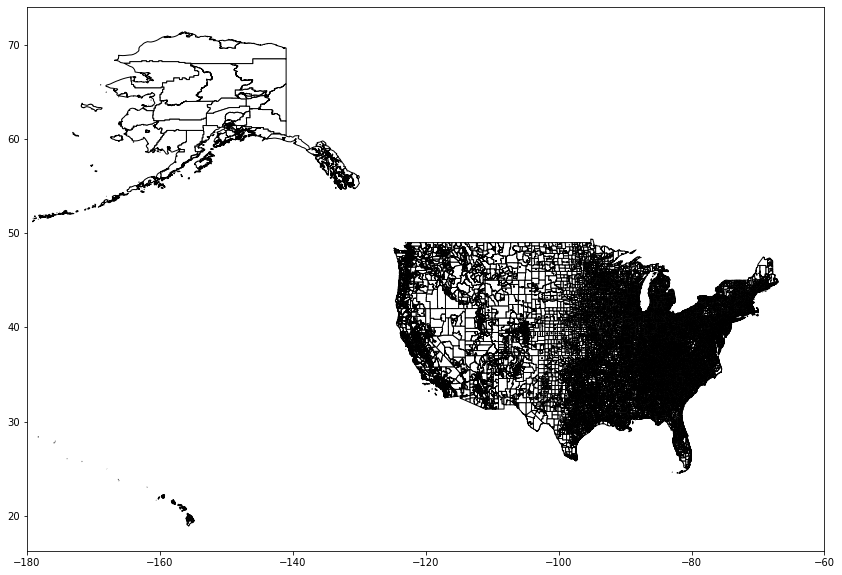

In [75]:
fig, ax = plt.subplots(figsize=(20, 10))
tract.plot(ax=ax, edgecolor='k', facecolor='w')
plt.xlim(-180, -60)

Save as `GeoJSON`

In [ ]:
tract.to_file('../data/tract.json',driver='GeoJSON')

### Save State and County names

In [ ]:
df = pd.merge(county[['geoid', 'statefp', 'name']], state[['statefp', 'name']], on='statefp', how='left')
df.rename(columns={'name_x': 'county', 'name_y': 'state'}, inplace=True)
d = (df.groupby('state')
       .apply(lambda x: list(x['county']))
       .to_dict())

with open('../data/state_county_names.json', 'w') as fp:
    json.dump(d, fp)

***
<a id='carto_data'></a>
## Preprocess carto data

### Read data

In [ ]:
# the four layers are provided from the same dataset
# search for the dataset
ds = lmi.Dataset(id_hash=datasets['carto']['riverine_flood_risk'])
ds

In [ ]:
#get the layer from the dataset
l = ds.layers[0]
l

### Use raw values

In [ ]:
#build the sql to select the 4 attributes at the same time
account = l.attributes['layerConfig']['account']

query = "SELECT s.aq30_id, s.gid_1, s.pfaf_id, s.string_id, s.drr_label, s.drr_cat, s.drr_raw, s.drr_score, s.cfr_label, s.cfr_cat, s.cfr_raw, s.cfr_score, s.rfr_label, s.rfr_cat, s.rfr_raw, s.rfr_score, r.the_geom \
FROM water_risk_indicators_annual_all s \
LEFT JOIN y2018m12d06_rh_master_shape_v01 r on s.aq30_id=r.aq30_id \
WHERE s.pfaf_id != -9999 and s.gid_1 != '-9999' and r.aqid != -9999 and  s.gid_1 like 'USA%'"
df_input = df_from_carto(account, query)

df_input = df_input[['rfr_raw', 'cfr_raw', 'drr_raw', 'geometry']]

df_input.rename(columns={'rfr_raw': 'rfr', 'cfr_raw': 'cfr', 'drr_raw': 'drr'}, inplace=True)

df_input = df_input[['rfr', 'cfr', 'drr', 'geometry']]
# Reproject
df_input = df_input.set_crs(epsg=4326, allow_override=True)
df_input = df_input.to_crs("EPSG:4326")
df_input.head()

**Check the inputs**

In [ ]:
#check the outputs
name = 'drr'

fig, ax = plt.subplots(figsize=(20, 10))
df_input.plot(name, ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

#### Intersect the geometries:

In [ ]:
for n, df in enumerate([state, county]):
    df_tmp = gpd.overlay(df, df_input, how='intersection')
    df_tmp['level'] = n+1
    # move level column
    cols = df_tmp.columns.tolist()
    df_tmp = df_tmp[cols[-1:] + cols[:-1]]
    
    if n == 0:
        df_out = df_tmp
    else:
        df_out = pd.concat([df_out, df_tmp])

#### Compute area of each geometry

In [ ]:
df_out['area'] = df_out.area
df_out.head()

#### Weighted mean

In [ ]:
# Weighted mean
df_tmp1 = weighted_mean(df_out[df_out['level'] == 1], columns=['rfr', 'cfr', 'drr'], weight_column='area', groupby_on='geoid')
# Merge with geometries
df_tmp1 = pd.merge(state, df_tmp1, on='geoid', how='left')
df_tmp1['level'] = 1
cols = df_tmp1.columns.tolist()
df_tmp1 = df_tmp1[cols[-1:] + cols[:-1]]

# Weighted mean
df_tmp2 = weighted_mean(df_out[df_out['level'] == 2], columns=['rfr', 'cfr', 'drr'], weight_column='area', groupby_on='geoid')
# Merge with geometries
df_tmp2 = pd.merge(county, df_tmp2, on='geoid', how='left')
df_tmp2['level'] = 2
cols = df_tmp2.columns.tolist()
df_tmp2 = df_tmp2[cols[-1:] + cols[:-1]]

df_carto = pd.concat([df_tmp1, df_tmp2])

df_carto.head()

**Export temporal json data with carto processing**

In [ ]:
#export temporal json data with carto processing
df_out.to_file(
    '../data/carto_data.json',
    driver='GeoJSON')

**Check the outputs**

`States`:

In [ ]:
#check the outputs
name = 'drr'
df = df_carto[df_carto['level'] == 1].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

`Counties`:

In [ ]:
name = 'drr'
df = df_carto[df_carto['level'] == 2].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

#### Compute scores category and ranges:

In [ ]:
q = [0,0.2,0.4,0.6,0.8,1]
scores = [0,1,2,3,4,5]
        
df_tmp1  = compute_score_category_label(df_carto[df_carto['level'] == 1], columns=['rfr', 'cfr', 'bws', 'drr'], q=q, scores=scores)
df_tmp2 = compute_score_category_label(df_carto[df_carto['level'] == 2], columns=['rfr', 'cfr', 'bws', 'drr'], q=q, scores=scores)

df_out_carto = pd.concat([df_tmp1, df_tmp2])

In [ ]:
df_out_carto.sort_values(['level','geoid'], inplace=True)

**Check the outputs**

`States`:

In [ ]:
#check the outputs
name = 'drr_cat'
df = df_out_carto[df_out_carto['level'] == 1].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap='RdYlBu_r')
plt.xlim(-180, -65)

`Counties`:

In [ ]:
#check the outputs
name = 'drr_cat'
df = df_out_carto[df_out_carto['level'] == 2].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

### Use scores

In [ ]:
#build the sql to select the 4 attributes at the same time
account = l.attributes['layerConfig']['account']
query = "SELECT s.aq30_id, s.gid_1, s.pfaf_id, s.string_id, s.drr_label, s.drr_cat, s.drr_raw, s.drr_score, s.cfr_label, s.cfr_cat, s.cfr_raw, s.cfr_score, s.rfr_label, s.rfr_cat, s.rfr_raw, s.rfr_score, r.the_geom \
FROM water_risk_indicators_annual_all s \
LEFT JOIN y2018m12d06_rh_master_shape_v01 r on s.aq30_id=r.aq30_id \
WHERE s.pfaf_id != -9999 and s.gid_1 != '-9999' and r.aqid != -9999 and  s.gid_1 like 'USA%'"
df_input = df_from_carto(account, query)
df_input = df_input[['rfr_score', 'cfr_score', 'drr_score', 'geometry']]

# Reproject
df_input = df_input.set_crs(epsg=4326, allow_override=True)
df_input = df_input.to_crs("EPSG:4326")
df_input.head()

#### Intersect the geometries:

In [ ]:
for n, df in enumerate([state, county, tract]):
    df_tmp = gpd.overlay(df, df_input, how='intersection')
    df_tmp['level'] = n+1
    # move level column
    cols = df_tmp.columns.tolist()
    df_tmp = df_tmp[cols[-1:] + cols[:-1]]
    
    if n == 0:
        df_out = df_tmp
    else:
        df_out = pd.concat([df_out, df_tmp])

#### Compute area of each geometry

In [ ]:
df_out['area'] = df_out.area
df_out.head()

#### Weighted mean

In [ ]:
for n, df in enumerate([state, county, tract]):
    # Weighted mean
    df_tmp = weighted_mean(df_out[df_out['level'] == n+1], columns=['rfr_score', 'cfr_score', 'drr_score'], weight_column='area', groupby_on='geoid')
    # Merge with geometries
    df_tmp = pd.merge(df, df_tmp, on='geoid', how='left')
    df_tmp['level'] = n+1
    cols = df_tmp.columns.tolist()
    df_tmp = df_tmp[cols[-1:] + cols[:-1]]
    
    if n == 0:
        df_carto = df_tmp
    else:
        df_carto = pd.concat([df_carto, df_tmp])
        
df_carto

#### Compute category and ranges:

In [ ]:
for indicator in ['rfr', 'cfr', 'drr']:
    df_carto[indicator] = df_carto[f'{indicator}_score']
    
for n in df_carto['level'].unique():
    df_tmp  = compute_category_label(df_carto[df_carto['level'] == n], columns=['rfr', 'cfr', 'drr'])

    if n == 1:
        df_out_carto = df_tmp
    else:
        df_out_carto = pd.concat([df_out_carto, df_tmp])

df_out_carto

In [ ]:
df_out_carto.sort_values(['level','geoid'], inplace=True)
df_out_carto.to_csv('../data/carto_indicators.csv')

**Check the outputs**

`States`:

In [ ]:
#check the outputs
name = 'rfr_cat'
df = df_out_carto[df_out_carto['level'] == 1].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap='RdYlBu_r')
plt.xlim(-180, -65)

`Counties`:

In [ ]:
#check the outputs
name = 'rfr_cat'
df = df_out_carto[df_out_carto['level'] == 2].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

`Census tracts`:

In [ ]:
#check the outputs
name = 'rfr_cat'
df = df_out_carto[df_out_carto['level'] == 3].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

In [ ]:
df_out_carto.to_csv('../data/carto_indicators.csv')

In [ ]:
#export temporal json data with carto processing
df_out_cat.to_file(
    '../data/carto_data_cat.json',
    driver='GeoJSON')

## 3. Preprocess Wildfire data:
### Read data

In [ ]:
wildfires = gpd.read_file('../data/wildfires/wildfires.shp')
wildfires.head()

### Intersect the geometries:

In [ ]:
for n, df in enumerate([state, county, tract]):
    number_fires, mean_fire_size, total_fire_size, per_total_fire_size = rtree_intersect(wildfires, df)
    
    df_tmp = df.copy()
    df_tmp['number_wlf'] = number_fires
    df_tmp['mean_size_wlf'] = mean_fire_size
    df_tmp['total_size_wlf'] = total_fire_size
    df_tmp['per_total_size_wlf'] = per_total_fire_size
    df_tmp['level'] = n+1 
    # move level column
    cols = df_tmp.columns.tolist()
    df_tmp = df_tmp[cols[-1:] + cols[:-1]]
    
    if n == 0:
        df_out = df_tmp
    else:
        df_out = pd.concat([df_out, df_tmp])
        
df_out.head()

In [ ]:
df_out

In [ ]:
df_out = df_out.rename(columns={'total_size_wlf': 'wlf'})
df_out = df_out[['level', 'geoid', 'statefp', 'name', 'bbox', 'geometry', 'countyfp', 'wlf']]

**Check the outputs**

`States`:

In [ ]:
#check the outputs
df = df_out[df_out['level'] == 1].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot('total_wlf_per', ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

`Counties`:

In [ ]:
#check the outputs
df = df_out[df_out['level'] == 2].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot('total_wlf_per', ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

`Census tracts`:

In [ ]:
#check the outputs
df = df_out[df_out['level'] == 3].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot('total_wlf_per', ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

#### Compute scores category and ranges:

In [ ]:
q = [0,0.2,0.4,0.6,0.8,1]
scores = [0,1,2,3,4,5]
    
for n in df_carto['level'].unique():
    df_tmp  = compute_score_category_label(df_out[df_out['level'] == n], columns=['wlf'], q=q, scores=scores)

    if n == 1:
        df_out_wlf = df_tmp
    else:
        df_out_wlf = pd.concat([df_out_wlf, df_tmp])

df_out_wlf

In [ ]:
df_out_wlf.sort_values(['level','geoid'], inplace=True)
df_out_wlf.to_csv('../data/wlf_indicators.csv')

**Check the outputs**

`States`:

In [ ]:
#check the outputs
name = 'wlf_cat'
df = df_out_wlf[df_out_wlf['level'] == 1].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

`Counties`

In [ ]:
#check the outputs
name = 'wlf_cat'
df = df_out_wlf[df_out_wlf['level'] == 2].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

`Census tracts`

In [ ]:
#check the outputs
name = 'wlf_cat'
df = df_out_wlf[df_out_wlf['level'] == 3].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

## 4. GEE data preprocessing:
### Read `xarray.Dataset` from `TIFF` in GCS

In [ ]:
file_names = {"efd": "dis.004_Earthquake_Frequency_and_Distribution.tif",
              "lss": "dis.007_Landslide_Susceptibility_replacement.tif",
              "vfd": "dis.008_Volcano_Frequency_and_Distribution.tif",
              "ehd": "cli.056a_Projected_Change_in_Extreme_Heat_Days.tif",
              "epd": "cli.059a_Projected_Change_in_Extreme_Precipitation_Days.tif"}

In [ ]:
datasets = {}
base_url = 'https://storage.googleapis.com/us-resilience-map/datasets/'
for name, file_name in file_names.items():
    print(f"Read xarray.Dataset from {file_name}")
    url = f'{base_url}{file_name}'
    xda = xr.open_rasterio(url).squeeze().drop("band")
    
    if name == 'ehd':
        # Replace all values equal to 0 with np.nan
        xda = xda.where(xda != 0.)
    else:
        # Replace all values equal to -9999 with np.nan
        xda = xda.where(xda != -9999.)
    
    # Rename coordinates 
    xda = xda.rename({'x': 'lon', 'y': 'lat'})
    
    # Convert the DataArray to a Dataset.
    ds = xda.to_dataset(name=name)
    
    datasets[name] = ds

**Check data**

`Landslide Susceptibility`:

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(datasets['lss']['lss'].values)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(datasets['epd']['epd'].values)

### Zonal statistics
**Create the data mask by rasterizing the vector data**

In [ ]:
masks = {'state': state,
        'county': county,
        'tract': tract}

for n, dataset in enumerate(datasets.items()):
    ds_name = dataset[0]
    ds = dataset[1]
    print(f"Creating data masks in {ds_name}")
    for mask_name, df in masks.items():
        df = masks[mask_name]
        df = df.reset_index().drop(columns='index').reset_index()
        print(f"Creating the data mask by rasterizing the vector data for {mask_name}")
        # Create the data mask by rasterizing the vector data
        ds[mask_name], index = create_ds_mask(df, ds, name, lon_name='lon', lat_name='lat')
        
        # Compute the mean value inside each geometry
        print(f"Computing the mean value inside each geometry")
        grouped_ds = ds.groupby(ds[mask_name])
        grid_mean = grouped_ds.mean()
        df_mean = grid_mean.to_dataframe()
        
        df_mean = df_mean[[ds_name]].reset_index().rename(columns={mask_name: 'index'})

        # Get centroid value for geometries smaller than mean cell size
        print(f"Getting centroid value for geometries smaller than mean cell size")
        if len(index) > 0:
            df_others = df[df['index'].isin(index)][['index', 'geometry']].copy()
            df_others['centroid'] = df['geometry'].apply(lambda x: list(x.centroid.coords)[0])

            values = []
            for centroid in  tqdm(df_others['centroid']):
                values.append(float(ds[ds_name].interp(lat=centroid[1], lon=centroid[0]).values))

            df_others[ds_name] = values
            df_mean = pd.concat([df_mean,df_others[['index', ds_name]]]).sort_values('index')  
            
        # Merge values with geometry GeoDataFrame
        if mask_name == 'state':
            if n == 0:
                df_tmp1 = pd.merge(df, df_mean, on='index', how='left')
                df_tmp1['level'] = 1
                cols = df_tmp1.columns.tolist()
                df_tmp1 = df_tmp1[cols[-1:] + cols[:-1]]
            else:
                df_tmp1[ds_name] = list(df_mean[ds_name])
        elif mask_name == 'county':
            if n == 0:
                df_tmp2 = pd.merge(df, df_mean, on='index', how='left')
                df_tmp2['level'] = 2
                cols = df_tmp2.columns.tolist()
                df_tmp2 = df_tmp2[cols[-1:] + cols[:-1]]
            else:
                df_tmp = pd.merge(df, df_mean, on='index', how='left')
                df_tmp2[ds_name] = list(df_tmp[ds_name])
        else:
            if n == 0:
                df_tmp3 = pd.merge(df, df_mean, on='index', how='left')
                df_tmp3['level'] = 3
                cols = df_tmp3.columns.tolist()
                df_tmp3 = df_tmp3[cols[-1:] + cols[:-1]]
            else:
                df_tmp = pd.merge(df, df_mean, on='index', how='left')
                df_tmp3[ds_name] = list(df_tmp[ds_name])
            
df_out = pd.concat([df_tmp1, df_tmp2, df_tmp3])

In [ ]:
df_out.head()

**Check the outputs**

`States`:

In [ ]:
name = 'ehd'
df = df_out[df_out['level'] == 1].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

`Counties`:

In [ ]:
df = df_out[df_out['level'] == 2].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

`Census tract`:

In [ ]:
df = df_out[df_out['level'] == 3].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

#### Compute scores category and labels:

In [ ]:
q = [0,0.2,0.4,0.6,0.8,1]
scores = [0,1,2,3,4,5]
    
for n in df_out['level'].unique():
    df_tmp  = compute_score_category_label(df_out[df_out['level'] == n], columns=['lss', 'ehd', 'epd'], q=q, scores=scores)

    if n == 1:
        df_out_score = df_tmp
    else:
        df_out_score = pd.concat([df_out_score, df_tmp])

df_out_score

#### Compute decile category and labels:

In [ ]:
df_out['efd'] = df_out['efd'].fillna(value=0)
df_out['vfd'] = df_out['vfd'].fillna(value=0)

df_out = df_out[['level', 'index', 'geoid', 'statefp', 'countyfp', 'name', 'bbox', 'geometry', 'efd', 'vfd']].copy()

for n in df_out['level'].unique():
    df_tmp  = compute_decile_category_label(df_out[df_out['level'] == n], columns=['efd', 'vfd'])

    if n == 1:
        df_out_decile = df_tmp
    else:
        df_out_decile = pd.concat([df_out_decile, df_tmp])

df_out_decile

In [ ]:
df_out_decile.rename(columns={'efd_decile': 'efd_score', 'vfd_decile': 'vfd_score'}, inplace=True)

In [ ]:
df_out_gee = pd.merge(df_out_score, df_out_decile.drop(columns=['level', 'index', 'statefp', 'countyfp', 'name', 'bbox', 'geometry']), on='geoid', how='left')
df_out_gee.sort_values(['level', 'geoid'], inplace=True)

In [ ]:
df_out_gee.to_csv('../data/gee_indicators.csv')

**Check the outputs**

`States`:

In [ ]:
#check the outputs
name = 'efd_cat'
df = df_out_gee[df_out_gee['level'] == 1].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

`Counties`:

In [ ]:
#check the outputs
name = 'efd_cat'
df = df_out_gee[df_out_gee['level'] == 2].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

## 5. Other datasets:
### 5.1. Population data:
Population data has been obtained from the following link: https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.pdf

In [ ]:
url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv"
pop_state_county = pd.read_csv(url,encoding='ISO-8859-1')
pop_state_county = pop_state_county[['STNAME','COUNTY','STATE', 'CTYNAME','POPESTIMATE2019']]
pop_state_county = pop_state_county.astype({'POPESTIMATE2019':'int32'})
pop_state_county.columns = map(str.lower, pop_state_county.columns)
pop_state_county.rename(columns={'popestimate2019':'pop'}, inplace=True)
pop_state_county.head()

#### Population by `State`

In [ ]:
state.head()

**Get population data by state**

In [ ]:
pop_state = pop_state_county[pop_state_county['county'] == 0]
pop_state = pop_state[['state', 'stname', 'pop']]
pop_state = pop_state.reset_index().drop(columns='index').reset_index()
pop_state.head()

**Merge state with the population dataset**

In [ ]:
pop_l1 =  pd.merge(state.astype({'statefp':'int32'}), pop_state[['state', 'pop']], left_on='statefp', right_on='state', how='left')
pop_l1 = gpd.GeoDataFrame(pop_l1)
pop_l1 = pop_l1[['geoid', 'statefp', 'name', 'pop', 'geometry']]
pop_l1['level'] = 1
pop_l1.head()

**Check the outputs**

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
pop_l1.plot('pop', ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

#### Population by `County`

In [ ]:
county.head()

**Get population data by county**

In [ ]:
pop_county = pop_state_county[pop_state_county['county'] != 0]
pop_county.head()

**Merge county with the population dataset**

In [ ]:
pop_l2 =  pd.merge(county.astype({'statefp':'int32', 'countyfp':'int32'}), pop_county[['stname', 'state', 'county', 'pop']].astype({'state':'object', 'county':'object'}), left_on=['statefp','countyfp'], right_on=['state','county'], how='left')
pop_l2 = gpd.GeoDataFrame(pop_l2)
pop_l2 = pop_l2[['geoid', 'countyfp', 'name', 'pop', 'geometry']]
pop_l2['level'] = 2
pop_l2.head()

**Check the outputs**

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
pop_l2.plot('pop', ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

In [ ]:
df_pop = pd.concat([pop_l1, pop_l2])
df_pop

#### Compute scores category and ranges:

In [ ]:
df_out = df_pop[['geoid', 'name', 'level', 'geometry', 'pop']]

In [ ]:
q = [0,0.2,0.4,0.6,0.8,1]
scores = [0,1,2,3,4,5]
        
df_tmp1  = compute_score_category_label(df_out[df_out['level'] == 1], columns=['pop'], q=q, scores=scores)
df_tmp2 = compute_score_category_label(df_out[df_out['level'] == 2], columns=['pop'], q=q, scores=scores)

df_out_pop = pd.concat([df_tmp1, df_tmp2])

In [ ]:
df_out_pop.sort_values(['level','geoid'], inplace=True)
df_out_pop.head()

**Check the outputs**

`States`:

In [ ]:
#check the outputs
name = 'pop_cat'
df = df_out_pop[df_out_pop['level'] == 1].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

`Counties`

In [ ]:
#check the outputs
name = 'pop_cat'
df = df_out_pop[df_out_pop['level'] == 2].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

### 5.2. [Poverty, Unemployment, and Median Household Income](https://www.ers.usda.gov/data-products/county-level-data-sets/):
Poverty, Unemployment, and Median Household Income data has been obtained from the following link: https://www.ers.usda.gov/data-products/county-level-data-sets/download-data/

**Variables:**
- Unemployment_rate_2019: Unemployment rate, 2019
- Median_Household_Income_2018: Estimate of Median household Income, 2018 ($)

In [ ]:
url = "https://www.ers.usda.gov/webdocs/DataFiles/48747/Unemployment.xls?v=7657.3"
mhi_state_county  = pd.read_excel(url, sheet_name='Unemployment Med HH Income', skiprows = range(0, 7), usecols=['FIPStxt', 'Stabr', 'area_name', 'Unemployment_rate_2019', 'Median_Household_Income_2018'])
mhi_state_county.columns = map(str.lower, mhi_state_county.columns)
mhi_state_county.rename(columns={'unemployment_rate_2019':'uep', 'median_household_income_2018':'mhi'}, inplace=True)
# Drop US
mhi_state_county.drop(index=0, inplace=True)
# Reset Index
mhi_state_county = mhi_state_county.reset_index().drop(columns='index')

In [ ]:
url = "https://www.ers.usda.gov/webdocs/DataFiles/48747/PovertyEstimates.xls?v=5138.5"
ppp_state_county  = pd.read_excel(url, sheet_name='Poverty Data 2018', skiprows = range(0, 4), usecols=['FIPStxt', 'Stabr', 'Area_name', 'PCTPOVALL_2018'])
ppp_state_county.columns = map(str.lower, ppp_state_county.columns)
ppp_state_county.rename(columns={'pctpovall_2018':'pvt'}, inplace=True)
# Drop US
ppp_state_county.drop(index=0, inplace=True)
# Reset Index
ppp_state_county = ppp_state_county.reset_index().drop(columns='index')

In [ ]:
mhi_state_county = pd.merge(mhi_state_county, ppp_state_county[['fipstxt', 'pvt']], on='fipstxt', how='left')
mhi_state_county.head()

#### Poverty, Unemployment, and Median Household Income by `State`
**Get population data by state**

In [ ]:
mhi_state = mhi_state_county[pd.Series([s.find(',') for s in list(mhi_state_county['area_name'])]) == -1]
mhi_state.drop(index=331, inplace=True)
mhi_state = mhi_state.reset_index().drop(columns='index')
mhi_state['statefp'] = mhi_state['fipstxt'].apply(lambda x: int(x/1000))
mhi_state.head()

**Merge state with the population dataset**

In [ ]:
mhi_l1 =  pd.merge(state.astype({'statefp':'int32'}), mhi_state[['statefp', 'uep', 'mhi', 'pvt']], on='statefp', how='left')
mhi_l1 = gpd.GeoDataFrame(mhi_l1)
mhi_l1 = mhi_l1[['geoid', 'statefp', 'name', 'uep', 'mhi', 'pvt', 'geometry']]
mhi_l1['level'] = 1
mhi_l1.head()

**Check the outputs**

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
mhi_l1.plot('mhi', ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

#### Poverty, Unemployment, and Median Household Income by `County`

**Get population data by county**

In [ ]:
mhi_county = mhi_state_county[pd.Series([s.find(',') for s in list(mhi_state_county['area_name'])]) != -1]
mhi_county = mhi_county.reset_index().drop(columns='index')
mhi_county.head()

**Merge county with the population dataset**

In [ ]:
mhi_l2 =  pd.merge(county.astype({'geoid':'int32'}), mhi_county[['fipstxt', 'uep', 'mhi', 'pvt']], left_on='geoid', right_on='fipstxt', how='left')
mhi_l2 = gpd.GeoDataFrame(mhi_l2)
mhi_l2 = mhi_l2[['geoid', 'countyfp', 'name', 'uep', 'mhi', 'pvt', 'geometry']]
mhi_l2['level'] = 2
mhi_l2.head()

**Check the outputs**

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
mhi_l2.plot('mhi', ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

In [ ]:
df_mhi = pd.concat([mhi_l1, mhi_l2])
df_mhi

#### Compute scores category and ranges:

In [ ]:
df_out = df_mhi[['geoid', 'name', 'level', 'geometry', 'uep', 'mhi', 'pvt']]

In [ ]:
q = [0,0.2,0.4,0.6,0.8,1]
scores = [0,1,2,3,4,5]
        
df_tmp1  = compute_score_category_label(df_out[df_out['level'] == 1], columns=['uep', 'mhi', 'pvt'], q=q, scores=scores)
df_tmp2 = compute_score_category_label(df_out[df_out['level'] == 2], columns=['uep', 'mhi', 'pvt'], q=q, scores=scores)

df_out_mhi = pd.concat([df_tmp1, df_tmp2])

In [ ]:
df_out_mhi.sort_values(['level','geoid'], inplace=True)

**Check the outputs**

`States`:

In [ ]:
#check the outputs
name = 'mhi_cat'
df = df_out_mhi[df_out_mhi['level'] == 1].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

`Counties`:

In [ ]:
#check the outputs
name = 'mhi_cat'
df = df_out_mhi[df_out_mhi['level'] == 2].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

### 5.3. [Community Resilience Estimate data](https://www.census.gov/data/experimental-data-products/community-resilience-estimates.html):
Community Resilience Estimate data has been obtained from the following link: https://www2.census.gov/data/experimental-data-products/community-resilience-estimates/2020/technical-document.pdf

In [ ]:
url = "https://www2.census.gov/data/experimental-data-products/community-resilience-estimates/2020/cre-2018-a11.csv"
cre_county = pd.read_csv(url,encoding='ISO-8859-1')
cre_county = cre_county[cre_county['tract'] == 0]
cre_county = cre_county[['stname','county','state', 'ctname','rfgrp', 'prednum', 'prednum_moe', 'predrt', 'predrt_moe', 'popuni']]
cre_county.head()

In [ ]:
len(cre_county)

We take only as an indicator the percentage of people at 3+ Risk Factors

In [ ]:
cre_county = cre_county[cre_county['rfgrp'] == '3PLRF']
cre_county.head()

**Community Resilience Estimate by `County`**

In [ ]:
county.head()

In [ ]:
#NOTE: the merge is not matching the data properly
#I've changed the merge on by two attributes (state and county)
cre_l2 = pd.merge(county.astype({'countyfp': int, 'statefp': int}), cre_county[['county','state', 'prednum', 'predrt', 'popuni']], left_on=['countyfp','statefp'], right_on=['county','state'], how='left')
cre_l2 = cre_l2[['geoid', 'countyfp', 'name', 'predrt', 'geometry']]
cre_l2['level'] = 2
cre_l2.rename(columns={'predrt': 'cre'}, inplace=True)
cre_l2.head()

`predrt` (Percentage of Residents in County with 3+ Risk Factors) es el indicador que queremos usar 

**Check outputs:**

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
cre_l2.plot('cre', ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

**Community Resilience Estimate by `State`**

Para calcular el `predrt` por stado agregar el `prednum` (Number of Residents in County with 3+ Risk Factors) y el `popuni` (Number of Residents in County) y sacar los porcentages.

#### Agregate by state:

In [ ]:
cre_state = cre_county[['state', 'prednum', 'popuni']].groupby(['state']).sum().reset_index()
cre_state['predrt'] = cre_state['prednum']/cre_state['popuni']*100
cre_state.head()

In [ ]:
cre_l1 = pd.merge(state.astype({'statefp': int}), cre_state[['state', 'predrt']], left_on='statefp', right_on='state', how='left')
cre_l1 = cre_l1[['geoid', 'statefp', 'name', 'predrt', 'geometry']]
cre_l1['level'] = 1
cre_l1.rename(columns={'predrt': 'cre'}, inplace=True)
cre_l1.head()

**Check outputs:**

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
cre_l1.plot('cre', ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

In [ ]:
df_cre = pd.concat([cre_l1, cre_l2])
df_cre

#### Compute scores category and ranges:

In [ ]:
df_out = df_cre[['geoid', 'name', 'level', 'geometry', 'cre']]

In [ ]:
q = [0,0.2,0.4,0.6,0.8,1]
scores = [0,1,2,3,4,5]
        
df_tmp1  = compute_score_category_label(df_out[df_out['level'] == 1], columns=['cre'], q=q, scores=scores)
df_tmp2 = compute_score_category_label(df_out[df_out['level'] == 2], columns=['cre'], q=q, scores=scores)

df_out_cre = pd.concat([df_tmp1, df_tmp2])

In [ ]:
df_out_cre.sort_values(['level','geoid'], inplace=True)

**Check the outputs**

`States`:

In [ ]:
#check the outputs
name = 'cre_cat'
df = df_out_cre[df_out_cre['level'] == 1].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

`Counties`:

In [ ]:
#check the outputs
name = 'cre_cat'
df = df_out_cre[df_out_cre['level'] == 2].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

### 5.4. [Economic damage from climate change](http://www.impactlab.org/research/estimating-economic-damage-from-climate-change-in-the-united-states/):

In [ ]:
df = pd.read_csv('http://www.globalpolicy.science/s/county_damages_by_sector.csv')

**Economic damage by `County`**

In [ ]:
ecd_l1 = pd.merge(left=county.astype({'geoid': int}), right=df.drop(columns=['State Code', 'State Code', 'County Name']).rename(columns={'County FIPS code': 'geoid'}), how='left', on='geoid')
ecd_l1.head()

**Economic damage by `State`**

Seleccionar los indicadores de interes y agregarlos

### 5.5. [CDC Social Vulnerability Index data](https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html):
CDC SVI Documentation: https://svi.cdc.gov/Documents/Data/2018_SVI_Data/SVI2018Documentation-508.pdf

In [ ]:
indicators = {'Name':['riverine flood risk', 'coastal flood risk', 'extreme heat days', 'extreme precipitation days',
             'drought risk', 'landslide susceptibility', 'earthquake frequency and distribution',
             'volcano frequency and distribution', 'wildfires'] + 
             ['socioeconomic status', 'percentage of persons below poverty', 'percentage of civilian (age 16+) unemployed', 'per capita income', 'percentage of persons with no high school diploma (age 25+)', 
              'household composition & disability','percentage of persons aged 65 and older', 'percentage of persons aged 17 and younger', 'percentage of civilian with a disability', 'percentage of single parent households with children under 18',
             'minority status & language', 'minority (all persons except white, non-Hispanic)', 'speaks english “less than well”',
             'housing type & transportation', 'multi-unit structures', 'mobile homes', 'crowding', 'no vehicle', 'group quarters'],
 'Slug':['rfr', 'cfr', 'ehd', 'epd','drr', 'lss', 'efd','vfd', 'wlf'] + 
        ['ses', 'pov', 'uep', 'pci', 'hsd', 'hcd', 'a6o', 'a1y', 'pcd', 'sph', 'msl', 'mnt', 'sen', 'htt', 'mus', 'mhm', 'cwd', 'vhc', 'gqt'],
 'Category': ['climate risk'] * 9 + ['vulnerability'] * 19,
 'Group': list(range(0, 9)) + [9, 9.1,9.2,9.3,9.4] + [10, 10.1,10.2,10.3,10.4]  + [11, 11.1,11.2] + [12, 12.1,12.2,12.3,12.4,12.5]}

indicators = pd.DataFrame(indicators)
indicators.to_csv('../data/indicators_list.csv')
indicators

In [20]:
indicators = {'group': ['climate risk'] * 9 + ['vulnerability'] * 19,
 'indicator':['riverine flood risk', 'coastal flood risk', 'extreme heat days', 'extreme precipitation days',
             'drought risk', 'landslide susceptibility', 'earthquake frequency and distribution',
             'volcano frequency and distribution', 'wildfires'] + 
             ['socioeconomic status', 'percentage of persons below poverty', 'percentage of civilian (age 16+) unemployed', 'per capita income', 'percentage of persons with no high school diploma (age 25+)', 
              'household composition & disability','percentage of persons aged 65 and older', 'percentage of persons aged 17 and younger', 'percentage of civilian with a disability', 'percentage of single parent households with children under 18',
             'minority status & language', 'minority (all persons except white, non-Hispanic)', 'speaks english “less than well”',
             'housing type & transportation', 'multi-unit structures', 'mobile homes', 'crowding', 'no vehicle', 'group quarters'],
 'slug':['rfr', 'cfr', 'ehd', 'epd','drr', 'lss', 'efd','vfd', 'wlf'] + 
        ['ses', 'pov', 'uep', 'pci', 'hsd', 'hcd', 'a6o', 'a1y', 'pcd', 'sph', 'msl', 'mnt', 'sen', 'htt', 'mus', 'mhm', 'cwd', 'vhc', 'gqt']}

indicators = pd.DataFrame(indicators)
indicators

,group,indicator,slug
0,climate risk,riverine flood risk,rfr
1,climate risk,coastal flood risk,cfr
2,climate risk,extreme heat days,ehd
3,climate risk,extreme precipitation days,epd
4,climate risk,drought risk,drr
5,climate risk,landslide susceptibility,lss
6,climate risk,earthquake frequency and distribution,efd
7,climate risk,volcano frequency and distribution,vfd
8,climate risk,wildfires,wlf
9,vulnerability,socioeconomic status,ses


`States`

In [ ]:
indicators = ['E_TOTPOP', 'E_POV', 'E_UNEMP', 'E_PCI', 'E_NOHSDP', 'E_AGE65', 'E_AGE17', 'E_DISABL', 'E_SNGPNT', 'E_MINRTY',
 'E_LIMENG', 'E_MUNIT', 'E_MOBILE', 'E_CROWD', 'E_NOVEH', 'E_GROUPQ']

svi_indicator = {
'SPL_THEME1': 'ses',
'EP_POV': 'pov',
'EP_UNEMP': 'uep',
'EP_PCI': 'pci',
'EP_NOHSDP': 'hsd',
'SPL_THEME2': 'hcd',
'EP_AGE65': 'a6o',
'EP_AGE17': 'a1y',
'EP_DISABL': 'pcd',
'EP_SNGPNT': 'sph',
'SPL_THEME3': 'msl',
'EP_MINRTY': 'mnt',
'EP_LIMENG': 'sen',
'SPL_THEME4': 'htt',
'EP_MUNIT': 'mus',
'EP_MOBILE': 'mhm',
'EP_CROWD': 'cwd',
'EP_NOVEH': 'vhc',
'EP_GROUPQ': 'gqt'}

THEME_indicator = {'SPL_THEME1': ['EPL_POV', 'EPL_UNEMP','EPL_PCI', 'EPL_NOHSDP'],
     'SPL_THEME2': ['EPL_AGE65', 'EPL_AGE17', 'EPL_DISABL', 'EPL_SNGPNT'],
     'SPL_THEME3': ['EPL_MINRTY', 'EPL_LIMENG'],
     'SPL_THEME4': ['EPL_MUNIT', 'EPL_MOBILE','EPL_CROWD', 'EPL_NOVEH', 'EPL_GROUPQ']}

In [ ]:
svi_state = pd.read_csv('https://svi.cdc.gov/Documents/Data/2018_SVI_Data/CSV/SVI2018_US_COUNTY.csv')
svi_state = svi_state[['ST'] + indicators]
svi_state = svi_state.sort_values('ST')
svi_state = svi_state.replace(-999, np.nan)
svi_state.head()

In [ ]:
indicators.remove('E_PCI')
e_svi_state = svi_state[['ST']+['E_PCI']].groupby('ST').mean().reset_index()
ep_svi_state =  svi_state[['ST']+ indicators].groupby('ST').sum().reset_index()

colm = 'E_PCI'
e_svi_state[colm.replace('E_', 'EP_')] = e_svi_state[colm]
e_svi_state.drop(columns=colm, inplace=True)

indicators.remove('E_TOTPOP')
for colm in indicators:
    ep_svi_state[colm.replace('E_', 'EP_')] = ep_svi_state[colm]/ep_svi_state['E_TOTPOP']*100
    ep_svi_state.drop(columns=colm, inplace=True)
ep_svi_state.drop(columns='E_TOTPOP', inplace=True)

svi_state = pd.merge(e_svi_state, ep_svi_state, on='ST', how='left')
svi_state.head()

In [ ]:
def compute_percentile(df, columns):
    df = df.copy()
    q = [0,0.2,0.4,0.6,0.8,1]
    scores = [0,0.2,0.4,0.6,0.8,1]
    for column in columns:
        df.sort_values(column, inplace=True)
        
        s = df[column]
        f, quantiles =quantile_interp_function(s,q,scores)

        # Add percentile
        df[column.replace('EP',  'EPL')] = df[column].apply(f)                                                      
        
    return df

In [ ]:
svi_state = compute_percentile(svi_state, [colm.replace('E_', 'EP_') for colm in ['E_PCI'] + indicators])
svi_state.head()

In [ ]:
for theme in THEME_indicator.keys():
    svi_state[theme] = svi_state[THEME_indicator[theme]].sum(axis=1)

svi_state.drop(columns=[colm.replace('E_', 'EPL_') for colm in ['E_PCI'] + indicators], inplace=True)

svi_state = svi_state.rename(columns=svi_indicator)
svi_state = svi_state.rename(columns={'ST': 'geoid'})
svi_state.columns = map(str.lower, svi_state.columns)
# add level
svi_state['level'] = 1
# add name
svi_state = pd.merge(state[['geoid', 'name']].astype({'geoid': int}), svi_state, on='geoid', how='left')
svi_state.sort_values('geoid', inplace=True)
svi_state = svi_state[['geoid', 'name', 'level'] + list(svi_indicator.values())]
svi_state.head()

`County`

In [ ]:
svi_indicator = {
'SPL_THEME1': 'ses',
'EP_POV': 'pov',
'EP_UNEMP': 'uep',
'E_PCI': 'pci',
'EP_NOHSDP': 'hsd',
'SPL_THEME2': 'hcd',
'EP_AGE65': 'a6o',
'EP_AGE17': 'a1y',
'EP_DISABL': 'pcd',
'EP_SNGPNT': 'sph',
'SPL_THEME3': 'msl',
'EP_MINRTY': 'mnt',
'EP_LIMENG': 'sen',
'SPL_THEME4': 'htt',
'EP_MUNIT': 'mus',
'EP_MOBILE': 'mhm',
'EP_CROWD': 'cwd',
'EP_NOVEH': 'vhc',
'EP_GROUPQ': 'gqt'}

In [ ]:
svi_county = pd.read_csv('https://svi.cdc.gov/Documents/Data/2018_SVI_Data/CSV/SVI2018_US_COUNTY.csv')
svi_county = svi_county[['ST','FIPS']+list(svi_indicator.keys())]
svi_county = svi_county.rename(columns=svi_indicator)
svi_county = svi_county.rename(columns={'FIPS': 'geoid'})
svi_county.columns = map(str.lower, svi_county.columns)
svi_county = svi_county.replace(-999, np.nan)
svi_county['level'] = 2
# add name
svi_county = pd.merge(county[['geoid', 'name']].astype({'geoid': int}), svi_county, on='geoid', how='left')
svi_county.sort_values('geoid', inplace=True)
svi_county = svi_county[['geoid', 'name', 'level'] + list(svi_indicator.values())]
svi_county.head()

`Census tract`

In [ ]:
svi_tract = pd.read_csv('https://svi.cdc.gov/Documents/Data/2018_SVI_Data/CSV/SVI2018_US.csv')
svi_tract = svi_tract[['ST','FIPS']+list(svi_indicator.keys())]
svi_tract = svi_tract.rename(columns=svi_indicator)
svi_tract = svi_tract.rename(columns={'FIPS': 'geoid'})
svi_tract.columns = map(str.lower, svi_tract.columns)
svi_tract = svi_tract.replace(-999, np.nan)
svi_tract['level'] = 3
# add name
svi_tract = pd.merge(tract[['geoid', 'name']].astype({'geoid': int}), svi_tract, on='geoid', how='left')
svi_tract = svi_tract[['geoid', 'name', 'level'] + list(svi_indicator.values())]
svi_tract.sort_values('geoid', inplace=True)
svi_tract.head()

In [ ]:
df_svi = pd.concat([svi_state, svi_county, svi_tract])
df_svi

In [ ]:
q = [0,0.2,0.4,0.6,0.8,1]
scores = [0,1,2,3,4,5]

for n in df_svi['level'].unique():
    df_tmp  = compute_score_category_label(df_svi[df_svi['level'] == n], columns=list(svi_indicator.values()), q=q, scores=scores)

    if n == 1:
        df_out_svi = df_tmp
    else:
        df_out_svi = pd.concat([df_out_svi, df_tmp])

df_out_svi

In [ ]:
df_out_svi.sort_values(['level', 'geoid'], inplace=True)
df_out_svi.to_csv('../data/svi_indicators.csv')

**Check the outputs**

`States`:

In [ ]:
#check the outputs
name = 'pov_cat'
df = df_out_svi[df_out_svi['level'] == 1].copy()
df = gpd.GeoDataFrame(pd.merge(df, state[['geoid', 'geometry']].astype({'geoid': int}), on='geoid', how='left'))
fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap='RdYlBu_r')
plt.xlim(-180, -65)  

`Counties`:

In [ ]:
#check the outputs
name = 'pov_cat'
df = df_out_svi[df_out_svi['level'] == 2].copy()
df = gpd.GeoDataFrame(pd.merge(df, county[['geoid', 'geometry']].astype({'geoid': int}), on='geoid', how='left'))
fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap='RdYlBu_r')
plt.xlim(-180, -65)  

`Census tracts`:

In [ ]:
#check the outputs
name = 'pov_cat'
df = df_out_svi[df_out_svi['level'] == 3].copy()
df = gpd.GeoDataFrame(pd.merge(df, tract[['geoid', 'geometry']].astype({'geoid': int}), on='geoid', how='left'))
fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap='RdYlBu_r')
plt.xlim(-180, -65) 

## 6. Merge all datasets:

In [157]:
svi_indicator = {
'SPL_THEME1': 'ses',
'EP_POV': 'pov',
'EP_UNEMP': 'uep',
'EP_PCI': 'pci',
'EP_NOHSDP': 'hsd',
'SPL_THEME2': 'hcd',
'EP_AGE65': 'a6o',
'EP_AGE17': 'a1y',
'EP_DISABL': 'pcd',
'EP_SNGPNT': 'sph',
'SPL_THEME3': 'msl',
'EP_MINRTY': 'mnt',
'EP_LIMENG': 'sen',
'SPL_THEME4': 'htt',
'EP_MUNIT': 'mus',
'EP_MOBILE': 'mhm',
'EP_CROWD': 'cwd',
'EP_NOVEH': 'vhc',
'EP_GROUPQ': 'gqt'}

indicartos = ['rfr', 'cfr', 'ehd', 'epd', 'drr', 'lss', 'efd','vfd', 'wlf']+list(svi_indicator.values())

In [158]:
df_carto = pd.read_csv('../data/carto_indicators.csv').drop(columns=['Unnamed: 0', 'statefp', 'countyfp', 'tractce', 'bbox', 'geometry'])
df_gee = pd.read_csv('../data/gee_indicators.csv').drop(columns=['Unnamed: 0', 'index', 'statefp', 'countyfp', 'bbox', 'geometry'])
df_wlf = pd.read_csv('../data/wlf_indicators.csv').drop(columns=['Unnamed: 0', 'statefp', 'countyfp', 'bbox', 'geometry'])
df_svi = pd.read_csv('../data/svi_indicators.csv').drop(columns='Unnamed: 0')

/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [163]:
#df_all = pd.merge(df_svi, df_carto, on=['geoid', 'level', 'name'], how='left')
#df_all = pd.merge(df_all, df_gee, on=['geoid', 'level', 'name'], how='left')
#df_all = pd.merge(df_all, df_wlf, on=['geoid', 'level', 'name'], how='left')
df_all = pd.merge(df_svi, df_carto, on=['geoid', 'level'], how='left')
df_all = pd.merge(df_all, df_gee, on=['geoid', 'level'], how='left')
df_all = pd.merge(df_all, df_wlf, on=['geoid', 'level'], how='left')
df_all.drop(columns='name_y', inplace=True)
df_all.rename(columns={'name_x': 'name'}, inplace=True)

In [164]:
df_all

,geoid,name,level,ses,pov,uep,pci,hsd,hcd,a6o,...,efd_score,efd_cat,efd_range,vfd_score,vfd_cat,vfd_range,wlf,wlf_score,wlf_cat,wlf_range
0,1,Alabama,1,2.465929,17.049426,3.040241,23072.835821,9.662362,2.661856,16.112715,...,1,0,"[0, 2]",0,0,"[0, 2]",1.412812e+06,2.983564,2,"[278101.3023904694, 1431773.9612935523]"
1,2,Alaska,1,1.913712,10.543441,3.800459,32531.206897,4.706736,1.601144,10.619675,...,3,1,"[2, 4]",0,0,"[0, 2]",7.081020e+06,4.738294,4,"[3166594.9036295014, 8468580.97975234]"
2,4,Arizona,1,2.329827,15.722492,3.026105,23459.400000,8.824382,2.612777,16.674428,...,2,0,"[0, 2]",1,0,"[0, 2]",2.803290e+06,3.790581,3,"[1431773.9612935523, 3166594.9036295014]"
3,5,Arkansas,1,2.101911,17.064298,2.533679,22442.733333,9.229668,3.167306,16.301893,...,1,0,"[0, 2]",0,0,"[0, 2]",3.919765e+06,4.142054,4,"[3166594.9036295014, 8468580.97975234]"
4,6,California,1,3.222085,14.016130,3.375591,32089.620690,11.432201,1.059468,13.577587,...,5,2,"[4, 6]",3,1,"[2, 4]",5.259801e+06,4.394797,4,"[3166594.9036295014, 8468580.97975234]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76019,56043000200,2,3,1.831400,9.700000,5.600000,30953.000000,9.600000,2.303300,21.400000,...,0,0,"[0, 2]",0,0,"[0, 2]",1.122771e+04,4.002810,4,"[6192.195694749798, 1798244.0173713344]"
76020,56043000301,3.01,3,1.978800,11.600000,3.700000,24938.000000,12.000000,2.462100,17.200000,...,0,0,"[0, 2]",0,0,"[0, 2]",0.000000e+00,0.000000,0,"[1.953793079609281e-06, 138.39040310853636]"
76021,56043000302,3.02,3,2.576800,16.300000,9.900000,25961.000000,10.100000,2.555800,23.400000,...,0,0,"[0, 2]",0,0,"[0, 2]",0.000000e+00,0.000000,0,"[1.953793079609281e-06, 138.39040310853636]"
76022,56045951100,9511,3,1.614200,17.500000,1.200000,29414.000000,8.800000,2.216900,20.500000,...,0,0,"[0, 2]",0,0,"[0, 2]",5.215562e+04,4.025648,4,"[6192.195694749798, 1798244.0173713344]"


In [165]:
all_indicators = []
for indicator in indicartos:
    all_indicators.append([indicator, f'{indicator}_score', f'{indicator}_cat', f'{indicator}_range'])
all_indicators = [item for sublist in all_indicators for item in sublist]

In [166]:
df_all = df_all[['geoid', 'name', 'level']+all_indicators]

In [167]:
state['geoid_int'] = state['geoid']
county['geoid_int'] = county['geoid']
tract['geoid_int'] = tract['geoid']

df_all = pd.concat([pd.merge(state[['geoid', 'geoid_int']].astype({'geoid_int':int}), df_all[df_all['level'] == 1], left_on='geoid_int', right_on='geoid', how='left')\
                    .drop(columns=['geoid_int', 'geoid_y']).rename(columns={'geoid_x': 'geoid'}),
    pd.merge(county[['geoid', 'geoid_int']].astype({'geoid_int':int}), df_all[df_all['level'] == 2], left_on='geoid_int', right_on='geoid', how='left')\
                    .drop(columns=['geoid_int', 'geoid_y']).rename(columns={'geoid_x': 'geoid'}),
    pd.merge(tract[['geoid', 'geoid_int']].astype({'geoid_int':int}), df_all[df_all['level'] == 3], left_on='geoid_int', right_on='geoid', how='left')\
                    .drop(columns=['geoid_int', 'geoid_y']).rename(columns={'geoid_x': 'geoid'})])

In [168]:
df_all

,geoid,name,name,level,rfr,rfr_score,rfr_cat,rfr_range,cfr,cfr_score,...,cwd_cat,cwd_range,vhc,vhc_score,vhc_cat,vhc_range,gqt,gqt_score,gqt_cat,gqt_range
0,01,Alabama,Alabama,1,0.502981,0.502981,0,"[0, 1]",0.089206,0.089206,...,0,"[0.5352400587568381, 0.6765940970715897]",2.371379,1.967538,1,"[2.11938032520563, 2.379833753565434]",2.442072,1.741804,1,"[2.1665511690987445, 2.537971623257258]"
1,02,Alaska,Alaska,1,1.692572,1.692572,1,"[1, 2]",0.363021,0.363021,...,4,"[1.257304297471353, 2.9097156246461924]",3.244209,3.953402,3,"[2.7367292711435045, 3.269011824064057]",3.710008,4.198594,4,"[3.195020972073734, 5.788183457073651]"
2,04,Arizona,Arizona,1,0.680378,0.680378,0,"[0, 1]",0.024659,0.024659,...,4,"[1.257304297471353, 2.9097156246461924]",2.303415,1.706594,1,"[2.11938032520563, 2.379833753565434]",2.245747,1.213225,1,"[2.1665511690987445, 2.537971623257258]"
3,05,Arkansas,Arkansas,1,0.839422,0.839422,0,"[0, 1]",0.000000,0.000000,...,3,"[0.8927565652292759, 1.257304297471353]",2.461621,2.229164,2,"[2.379833753565434, 2.7367292711435045]",2.815823,3.098129,3,"[2.774563771974365, 3.195020972073734]"
4,06,California,California,1,1.179035,1.179035,1,"[1, 2]",0.110282,0.110282,...,4,"[1.257304297471353, 2.9097156246461924]",2.398630,2.052667,2,"[2.379833753565434, 2.7367292711435045]",2.093244,0.916384,0,"[1.2898374154805807, 2.1665511690987445]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72826,56043000200,2,2,3,1.986667,1.986667,1,"[1, 2]",0.000000,0.000000,...,2,"[1.9, 3.3]",4.600000,2.133333,2,"[4.2, 7.199999999999999]",2.100000,3.227273,3,"[1.6, 3.8]"
72827,56043000301,3.01,3.01,3,2.006692,2.006692,2,"[2, 3]",0.000000,0.000000,...,1,"[1.0, 1.9]",8.000000,3.129032,3,"[7.199999999999999, 13.4]",1.400000,2.800000,2,"[0.6, 1.6]"
72828,56043000302,3.02,3.02,3,2.006692,2.006692,2,"[2, 3]",0.000000,0.000000,...,0,"[0.1, 1.0]",2.300000,1.050000,1,"[2.2, 4.2]",2.600000,3.454545,3,"[1.6, 3.8]"
72829,56045951100,9511,9511,3,0.211906,0.211906,0,"[0, 1]",0.000000,0.000000,...,3,"[3.3, 6.2]",3.300000,1.550000,1,"[2.2, 4.2]",8.700000,4.050936,4,"[3.8, 100.0]"


Save as `csv`

In [173]:
df_all.to_csv("../data/indicators.csv")

In [182]:
df = pd.read_csv("../data/indicators.csv")

/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [183]:
df

,Unnamed: 0,geoid,name,name.1,level,rfr,rfr_score,rfr_cat,rfr_range,cfr,...,cwd_cat,cwd_range,vhc,vhc_score,vhc_cat,vhc_range,gqt,gqt_score,gqt_cat,gqt_range
0,0,1,Alabama,Alabama,1,0.502981,0.502981,0,"[0, 1]",0.089206,...,0,"[0.5352400587568381, 0.6765940970715897]",2.371379,1.967538,1,"[2.11938032520563, 2.379833753565434]",2.442072,1.741804,1,"[2.1665511690987445, 2.537971623257258]"
1,1,2,Alaska,Alaska,1,1.692572,1.692572,1,"[1, 2]",0.363021,...,4,"[1.257304297471353, 2.9097156246461924]",3.244209,3.953402,3,"[2.7367292711435045, 3.269011824064057]",3.710008,4.198594,4,"[3.195020972073734, 5.788183457073651]"
2,2,4,Arizona,Arizona,1,0.680378,0.680378,0,"[0, 1]",0.024659,...,4,"[1.257304297471353, 2.9097156246461924]",2.303415,1.706594,1,"[2.11938032520563, 2.379833753565434]",2.245747,1.213225,1,"[2.1665511690987445, 2.537971623257258]"
3,3,5,Arkansas,Arkansas,1,0.839422,0.839422,0,"[0, 1]",0.000000,...,3,"[0.8927565652292759, 1.257304297471353]",2.461621,2.229164,2,"[2.379833753565434, 2.7367292711435045]",2.815823,3.098129,3,"[2.774563771974365, 3.195020972073734]"
4,4,6,California,California,1,1.179035,1.179035,1,"[1, 2]",0.110282,...,4,"[1.257304297471353, 2.9097156246461924]",2.398630,2.052667,2,"[2.379833753565434, 2.7367292711435045]",2.093244,0.916384,0,"[1.2898374154805807, 2.1665511690987445]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76019,72826,56043000200,2,2,3,1.986667,1.986667,1,"[1, 2]",0.000000,...,2,"[1.9, 3.3]",4.600000,2.133333,2,"[4.2, 7.199999999999999]",2.100000,3.227273,3,"[1.6, 3.8]"
76020,72827,56043000301,3.01,3.01,3,2.006692,2.006692,2,"[2, 3]",0.000000,...,1,"[1.0, 1.9]",8.000000,3.129032,3,"[7.199999999999999, 13.4]",1.400000,2.800000,2,"[0.6, 1.6]"
76021,72828,56043000302,3.02,3.02,3,2.006692,2.006692,2,"[2, 3]",0.000000,...,0,"[0.1, 1.0]",2.300000,1.050000,1,"[2.2, 4.2]",2.600000,3.454545,3,"[1.6, 3.8]"
76022,72829,56045951100,9511,9511,3,0.211906,0.211906,0,"[0, 1]",0.000000,...,3,"[3.3, 6.2]",3.300000,1.550000,1,"[2.2, 4.2]",8.700000,4.050936,4,"[3.8, 100.0]"


In [177]:
df = pd.read_csv("../data/indicators.csv")
df.drop(columns='Unnamed: 0', inplace=True)
df = df[df['level'] == 3]
df = pd.merge(df,tract.astype({'geoid': int}), how='left', on='geoid')
df = gpd.GeoDataFrame(df)
df.head()

/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,geoid,name_x,name.1,level,rfr,rfr_score,rfr_cat,rfr_range,cfr,cfr_score,...,gqt_score,gqt_cat,gqt_range,statefp,countyfp,tractce,name_y,bbox,geometry,geoid_int
0,1001020100,201,201,3,1.119658,1.119658,1,"[1, 2]",0.0,0.0,...,0.000000,0,"[0.1, 0.3]",01,001,020100,201,"[-86.510291, 32.449726999999996, -86.475243999...","POLYGON ((-86.50916 32.47344, -86.50620 32.475...",01001020100
1,1001020200,202,202,3,1.119658,1.119658,1,"[1, 2]",0.0,0.0,...,4.064449,4,"[3.8, 100.0]",01,001,020200,202,"[-86.48113099999999, 32.456206, -86.4653759999...","POLYGON ((-86.48093 32.48154, -86.47945 32.485...",01001020200
2,1001020300,203,203,3,1.119658,1.119658,1,"[1, 2]",0.0,0.0,...,0.000000,0,"[0.1, 0.3]",01,001,020300,203,"[-86.470871, 32.459213999999996, -86.450679, 3...","POLYGON ((-86.47087 32.47573, -86.46964 32.478...",01001020300
3,1001020400,204,204,3,1.119658,1.119658,1,"[1, 2]",0.0,0.0,...,0.000000,0,"[0.1, 0.3]",01,001,020400,204,"[-86.453936, 32.44721, -86.43246099999999, 32....","POLYGON ((-86.45394 32.49318, -86.45308 32.493...",01001020400
4,1001020500,205,205,3,1.119658,1.119658,1,"[1, 2]",0.0,0.0,...,3.090909,3,"[1.6, 3.8]",01,001,020500,205,"[-86.43816199999999, 32.423997, -86.4113479999...","POLYGON ((-86.43816 32.45069, -86.43773 32.451...",01001020500


(-180.0, -65.0)

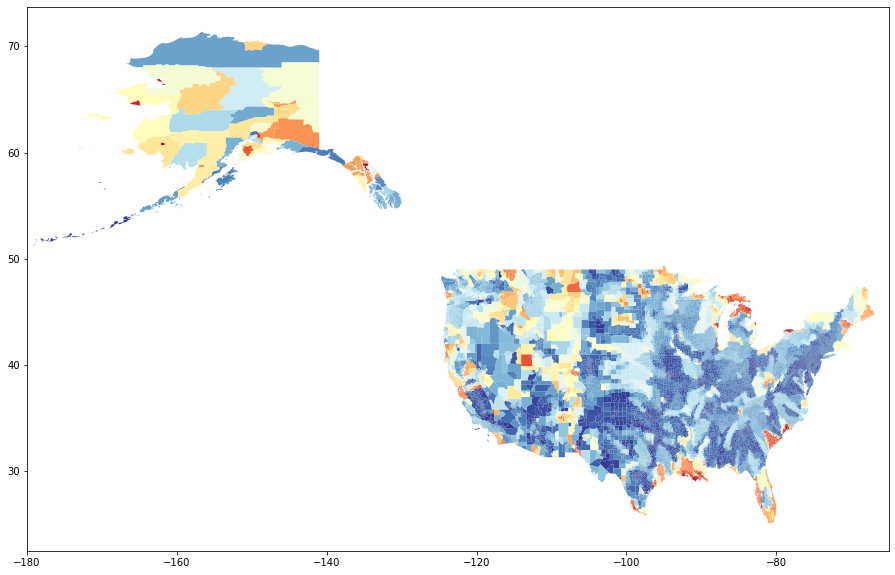

In [179]:
#check the outputs
name = 'rfr_score'

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

In [91]:
indicators

,group,indicator,slug,state_labels,county_labels,tract_labels,title,description,source
0,climate risk,riverine flood risk,rfr,"[Data not available, Less than 1 in 1k, 1 in 1...","[Data not available, Less than 1 in 1k, 1 in 1...","[Data not available, Less than 1 in 1k, 1 in 1...",Riverine flood risk,Riverine flood risk measures the percentage of...,https://www.wri.org/publication/aqueduct-30
1,climate risk,coastal flood risk,cfr,"[Data not available, Less than 9 in 1M, 9 in 1...","[Data not available, Less than 9 in 1M, 9 in 1...","[Data not available, Less than 9 in 1M, 9 in 1...",Coastal flood risk,Coastal flood risk measures the percentage of ...,https://www.wri.org/publication/aqueduct-30
2,climate risk,extreme heat days,ehd,"[Data not available, Less than 11 days, 11 to ...","[Data not available, Less than 12 days, 12 to ...","[Data not available, Less than 10 days, 10 to ...",Projected Change in Extreme Heat Days (2030),The Projected Change in Extreme Heat Days in t...,http://loca.ucsd.edu/
3,climate risk,extreme precipitation days,epd,"[Data not available, Less than 1.07 days, 1.07...","[Data not available, Less than 1.06 days, 1.06...","[Data not available, Less than 1.04 days, 1.04...",Projected Change in Extreme Precipitation Days...,The Projected Change in Extreme Precipitation ...,http://loca.ucsd.edu/
4,climate risk,drought risk,drr,"[Data not available, 0.0 to 0.2, 0.2 to 0.4, 0...","[Data not available, 0.0 to 0.2, 0.2 to 0.4, 0...","[Data not available, 0.0 to 0.2, 0.2 to 0.4, 0...",Drought risk,Drought risk measures where droughts are likel...,https://www.wri.org/publication/aqueduct-30
5,climate risk,landslide susceptibility,lss,"[Slight, Low, Moderate, High, Severe]","[Slight, Low, Moderate, High, Severe]","[Slight, Low, Moderate, High, Severe]",Landslide susceptibility,"The Landslide Susceptibility Map, created by s...",https://pmm.nasa.gov/applications/global-lands...
6,climate risk,earthquake frequency and distribution,efd,"[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...","[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...","[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...",Earthquake hazards - frequency (deciles),The Earthquake Hazard Frequency and Distributi...,http://sedac.ciesin.columbia.edu/data/set/ndh-...
7,climate risk,volcano frequency and distribution,vfd,"[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...","[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...","[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...",Volcano hazards - frequency (deciles),The Volcano Hazard Frequency and Distribution ...,http://sedac.ciesin.columbia.edu/data/set/ndh-...
8,climate risk,wildfires,wlf,"[Less than 30 kha, 30 kha to 280 kha, 280 kha ...","[Less than 1 kha, 1 kha to 4 kha, 4 kha to 10 ...","[Less than 140 ha, 140 ha to 540 ha, 540 ha to...",Total hectares burned (2001-2017),Total hectares burned (2001-2017) has been obt...,https://doi.pangaea.de/10.1594/PANGAEA.895835
9,vulnerability,socioeconomic status,ses,"[0.6 to 1.3th, 1.3 to 2.0th, 2.0 to 2.3th, 2.3...","[Data not available, 0.1 to 1.0th, 1.0 to 1.6t...","[Data not available, 0.0 to 1.0th, 1.0 to 1.6t...",socioeconomic status,,https://www.atsdr.cdc.gov/placeandhealth/svi/d...
